# Visualizing cluster feature heatmaps and survival curves

This notebook illustrates how to generate the cluster feature heatmap and cluster survival curve plots in our paper.

Author: George H. Chen (georgechen [at symbol] cmu.edu)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
%config InlineBackend.figure_format='retina'
from lifelines import KaplanMeierFitter
plt.style.use('seaborn')
import seaborn as sns
sns.color_palette('pastel')

from visualization_utils import transform, heatmap_plot, compute_SFT_survival_curves, compute_median_survival_times

### Load in data & auxiliary information

In [2]:
dataset = 'support'
visualization_dir = 'example_out_kernets_nosplit/visualization/kernet_tuna=xgb_support_exp0_pf1.000000_a0.010000_s0.100000_nd0_g0.000000_b0.500000_mkw0.010000_sr0.100000_nn128_nla2_nno128_bs1024_nep9_lr0.001000_sft'
raw_features = np.load(os.path.join(visualization_dir, 'train_raw_input.npy'))
labels = np.load(os.path.join(visualization_dir, 'train_labels.npy'))
duration_index = np.load(os.path.join(visualization_dir, 'duration_index.npy'))
embeddings = np.load(os.path.join(visualization_dir, 'train_embeddings.npy'))
exemplar_assignments = np.load(os.path.join(visualization_dir, 'exemplar_assignments.npy'), allow_pickle=True)
exemplar_labels = np.load(os.path.join(visualization_dir, 'exemplar_labels.npy'))
baseline_event_counts = np.load(os.path.join(visualization_dir, 'baseline_event_counts.npy'))
baseline_at_risk_counts = np.load(os.path.join(visualization_dir, 'baseline_at_risk_counts.npy'))
n_exemplars = len(exemplar_assignments)
exemplar_sizes = [len(exemplar_assignments[idx]) for idx in range(len(exemplar_assignments))]
exemplar_embeddings = embeddings[np.array([_[0] for _ in exemplar_assignments], dtype=int)]
units = 'days'

In [3]:
print('Number of exemplars/clusters:', n_exemplars)

Number of exemplars/clusters: 73


In [4]:
# compute survival curves from summary fine-tuning (SFT)
exemplar_SFT_survival_curves = compute_SFT_survival_curves(exemplar_labels, baseline_event_counts, baseline_at_risk_counts)

In [5]:
# compute each cluster's Kaplan-Meier curve & max observed time
exemplar_kaplan_meier_curves = []
max_observed_times = []
for exemplar_idx in range(n_exemplars):
    exemplar_kaplan_meier_curves.append(KaplanMeierFitter())
    observed_times, event_indicators = labels[exemplar_assignments[exemplar_idx]].T
    exemplar_kaplan_meier_curves[-1].fit(observed_times, event_indicators)
    max_observed_times.append(observed_times.max())
max_observed_times = np.array(max_observed_times)

<ipython-input-6-7e12917235a5>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-6-7e12917235a5>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-6-7e12917235a5>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-6-7e12917235a5>:4: RuntimeWarni

<ipython-input-6-7e12917235a5>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-6-7e12917235a5>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-6-7e12917235a5>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-6-7e12917235a5>:4: RuntimeWarni

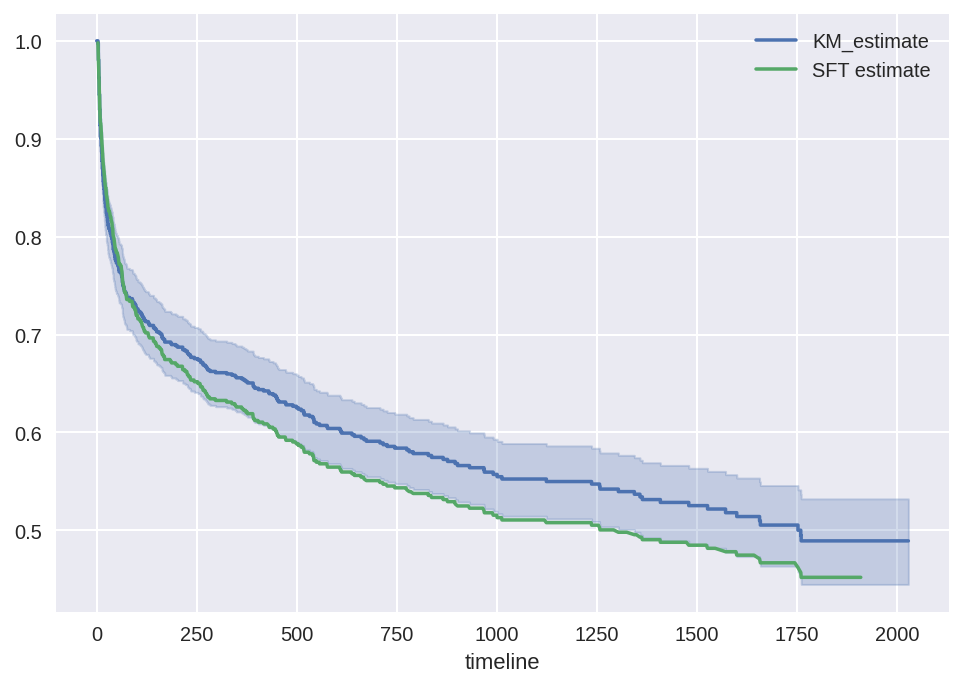

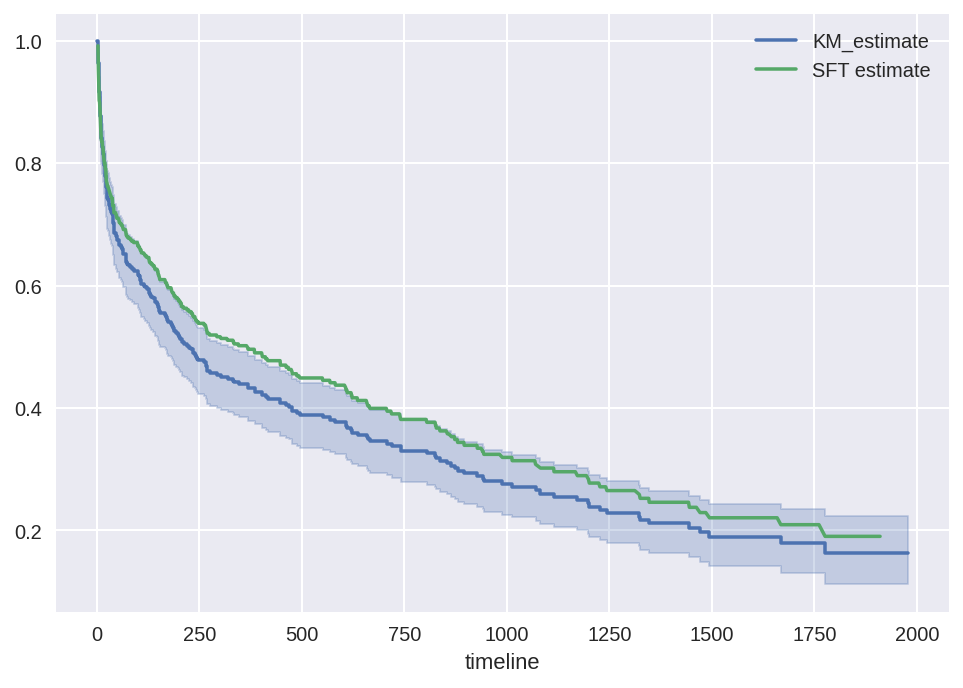

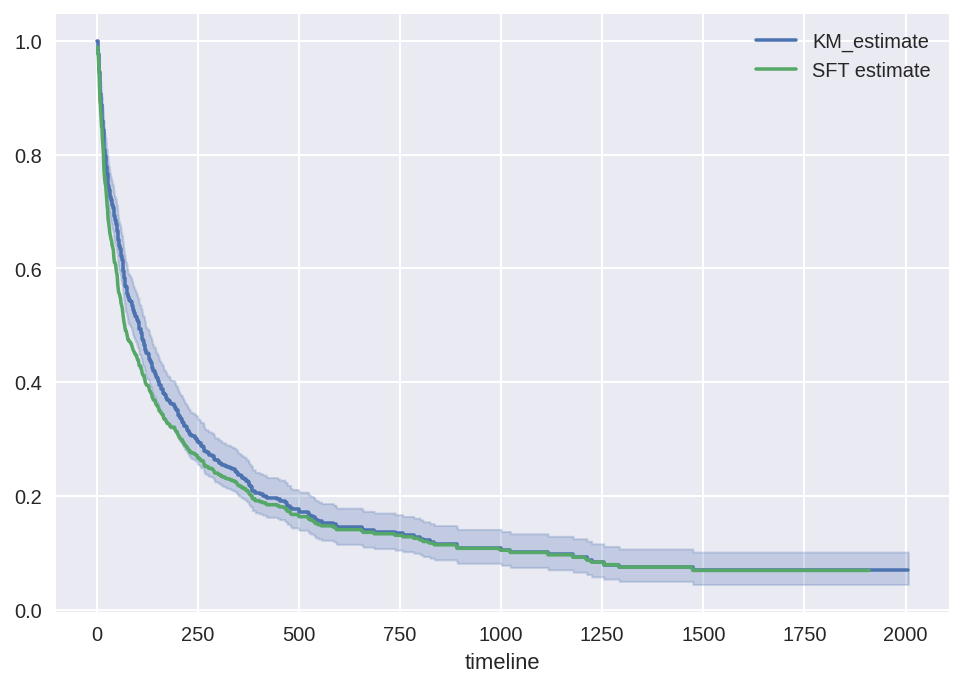

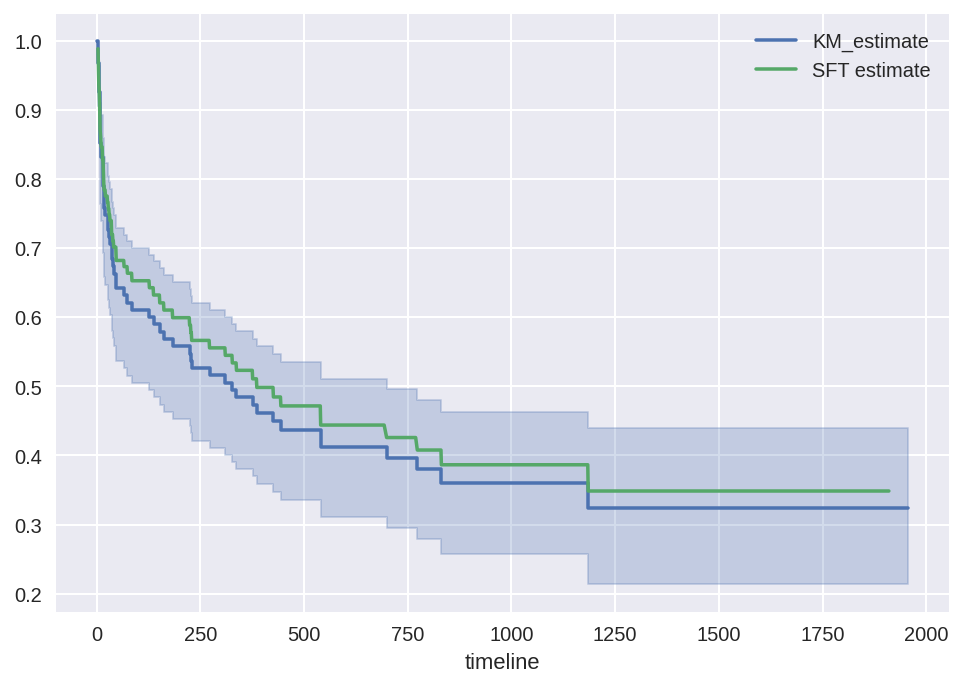

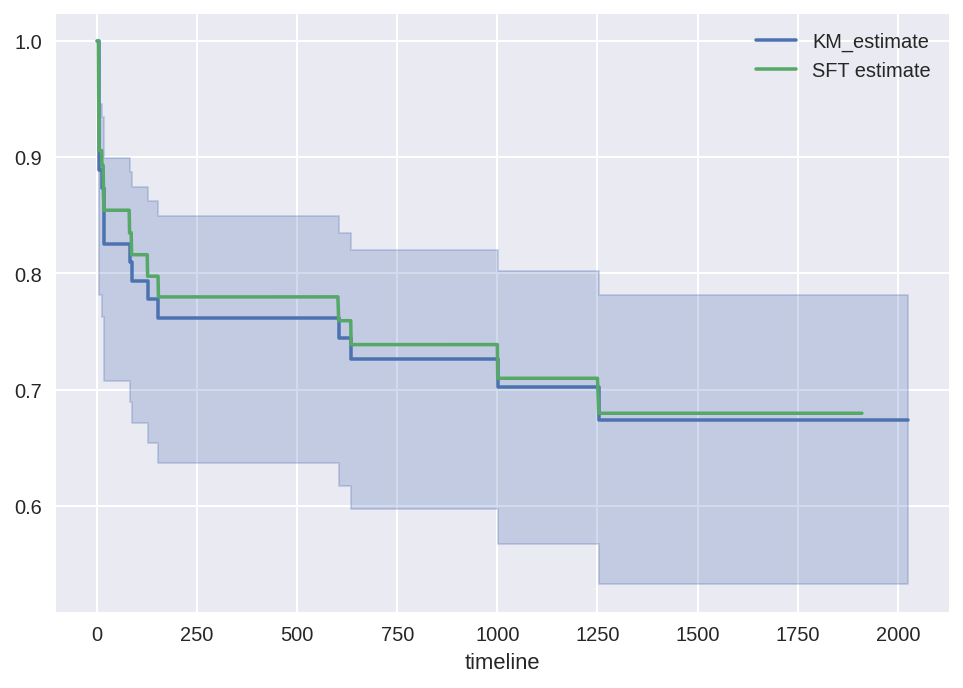

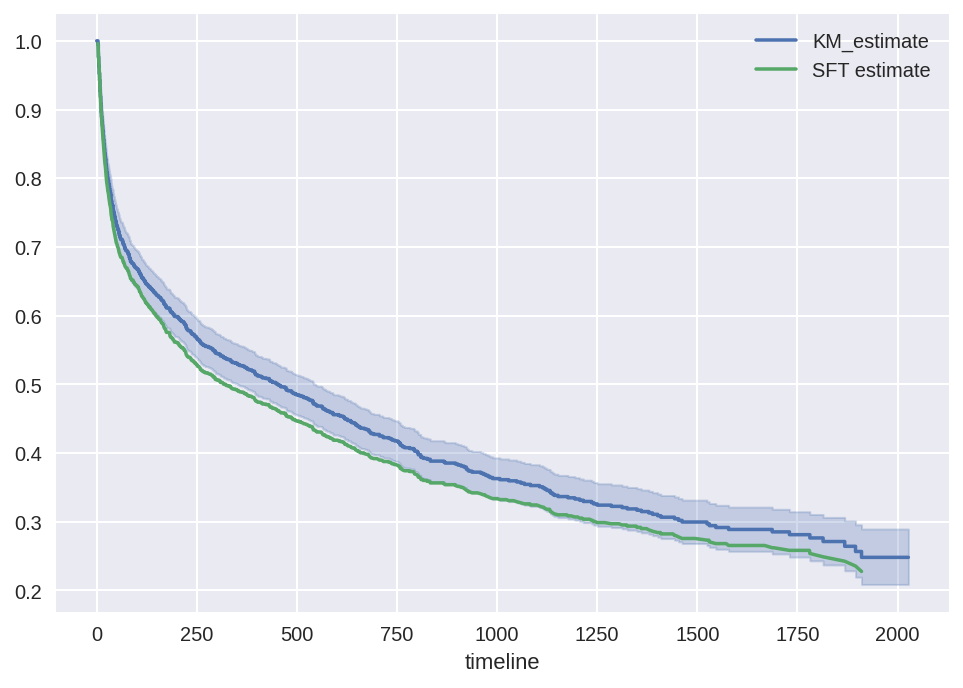

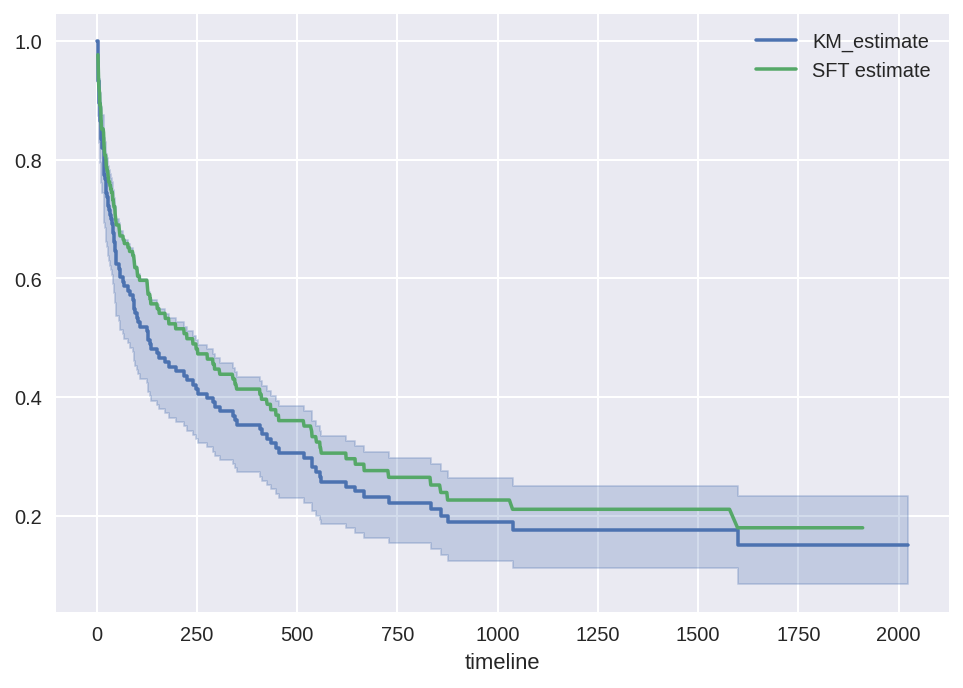

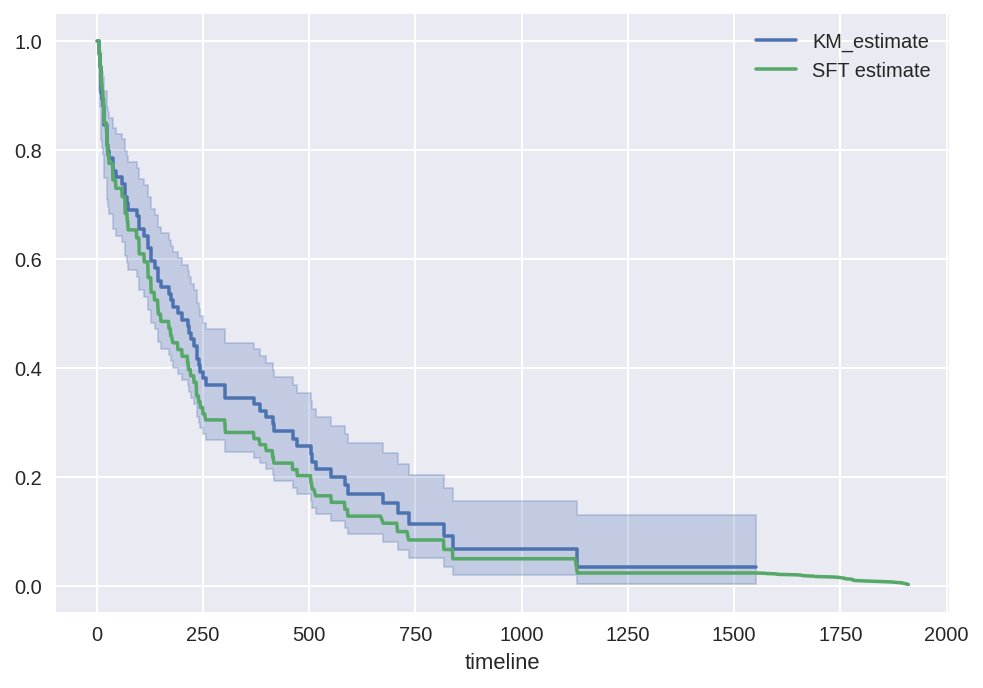

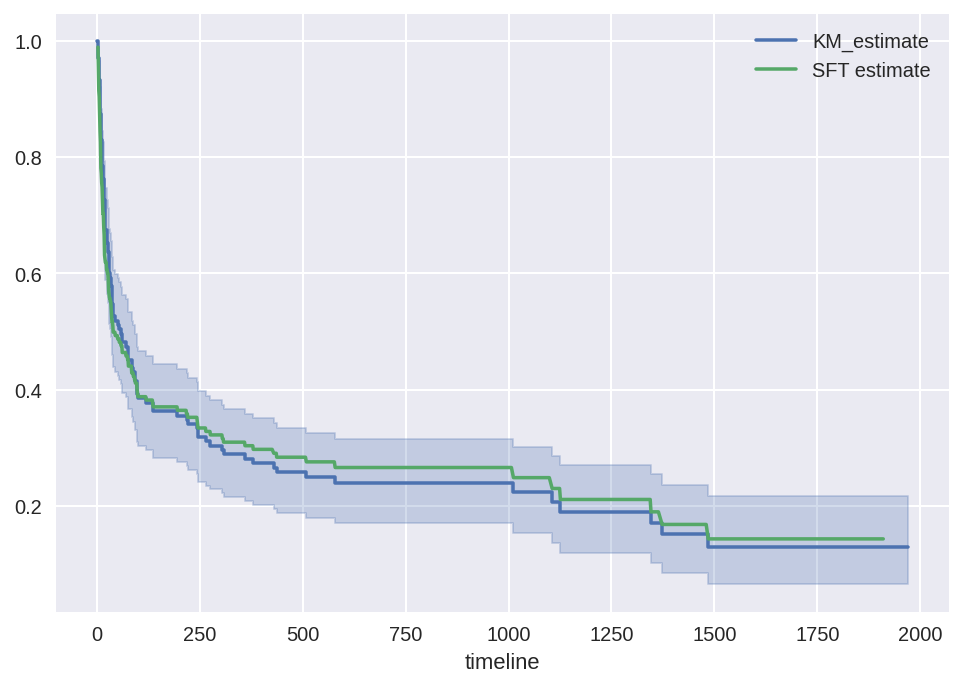

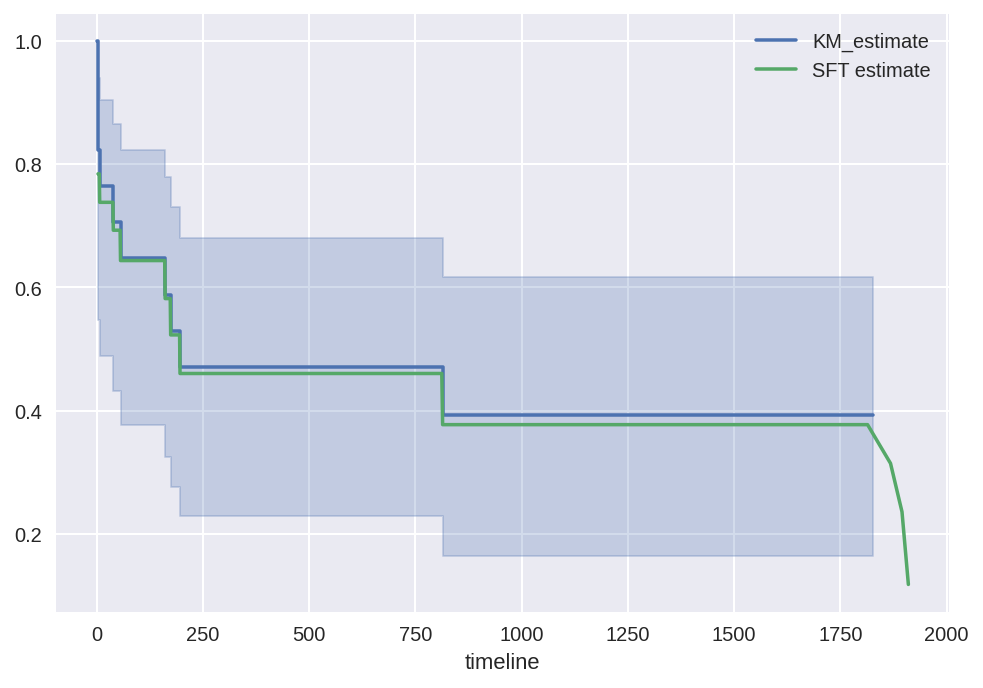

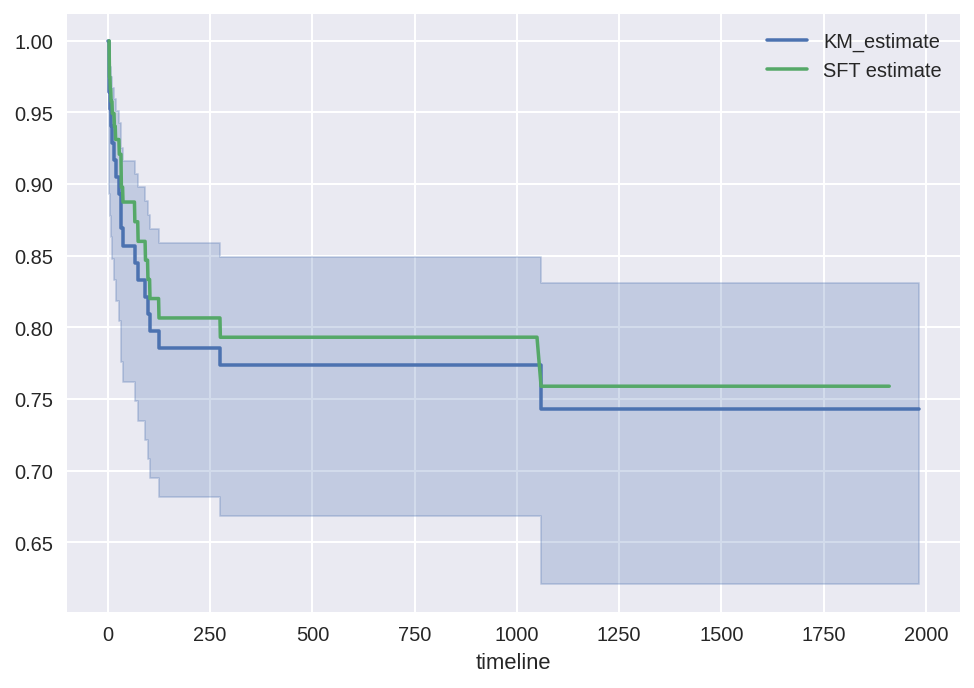

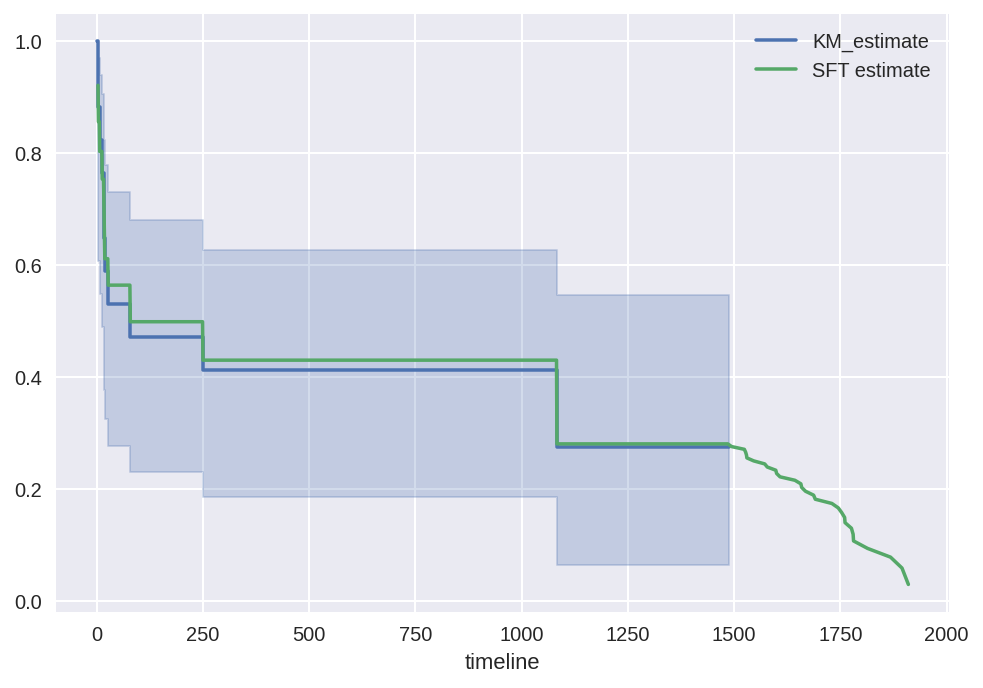

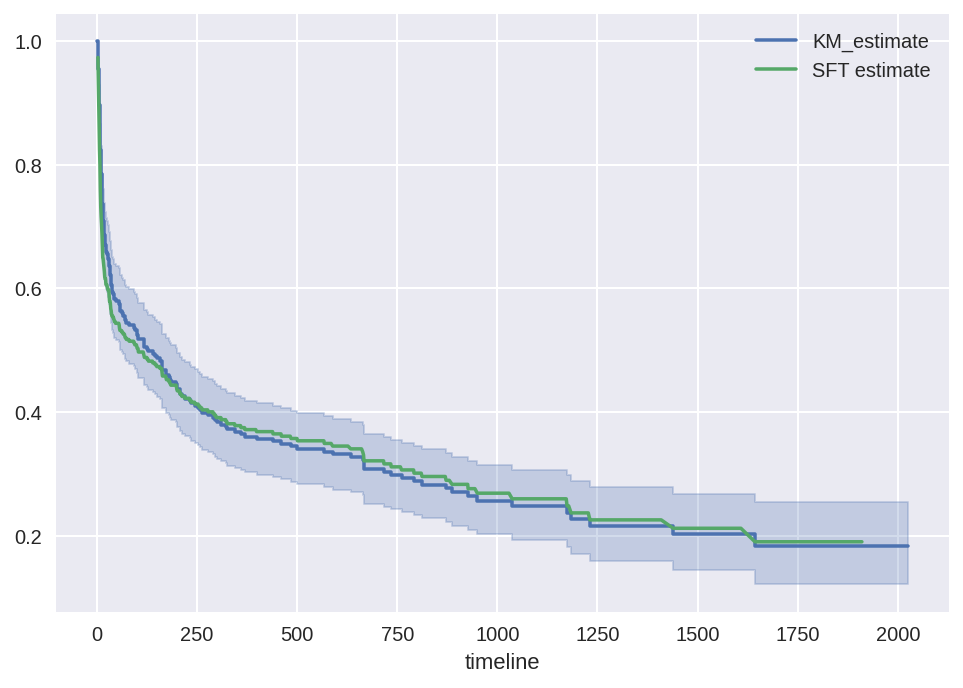

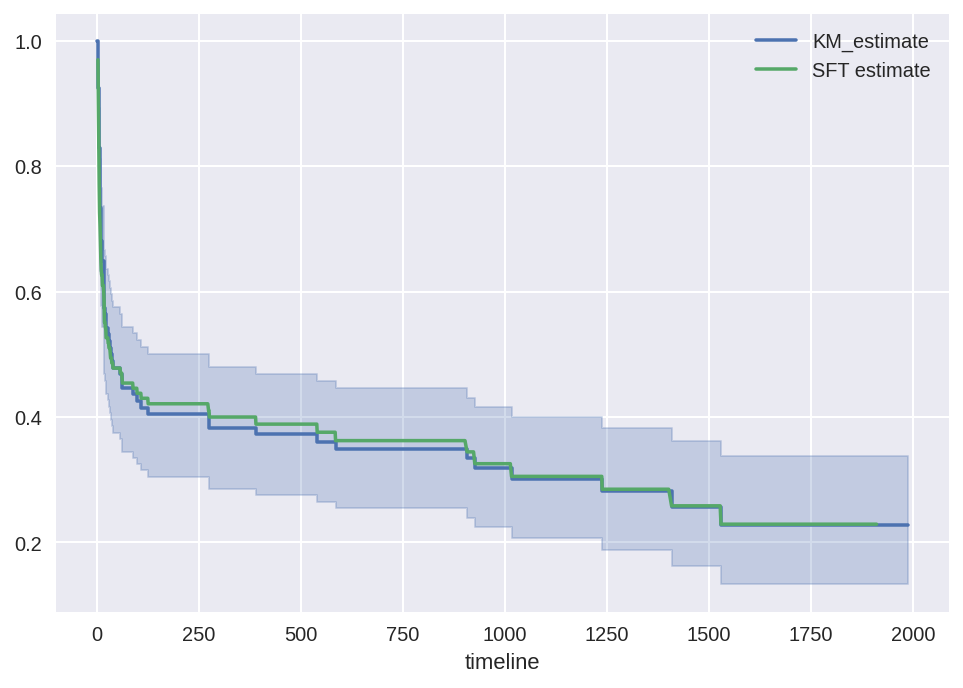

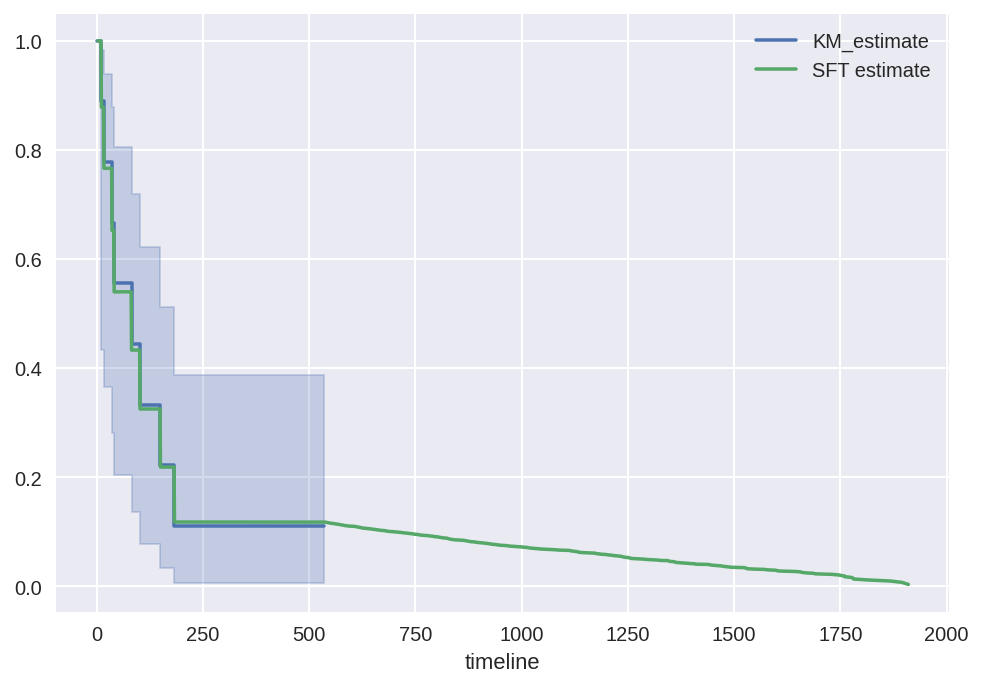

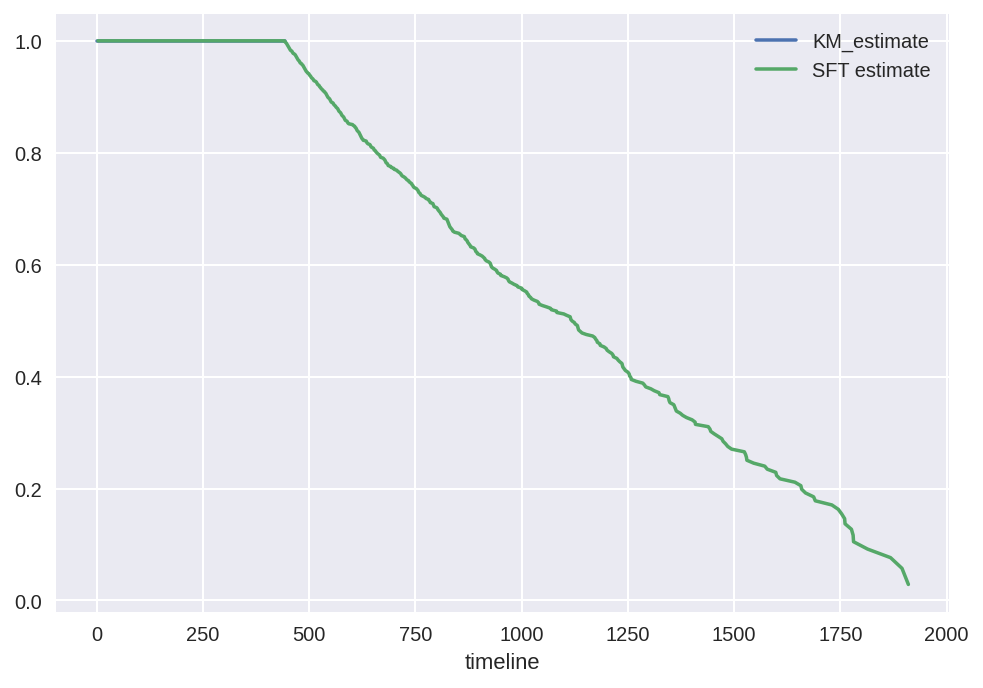

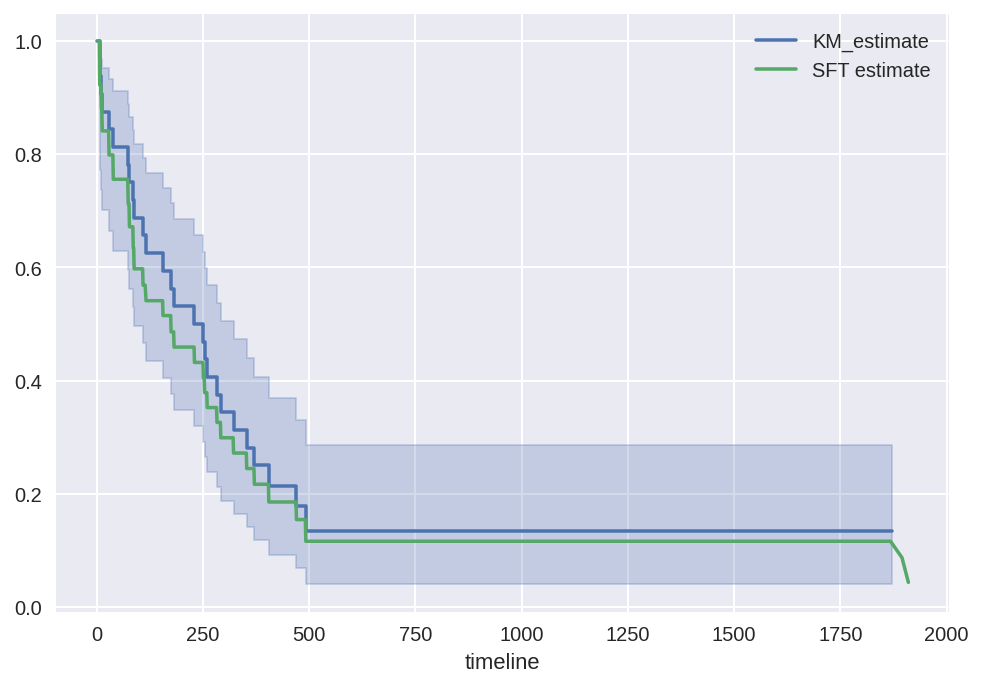

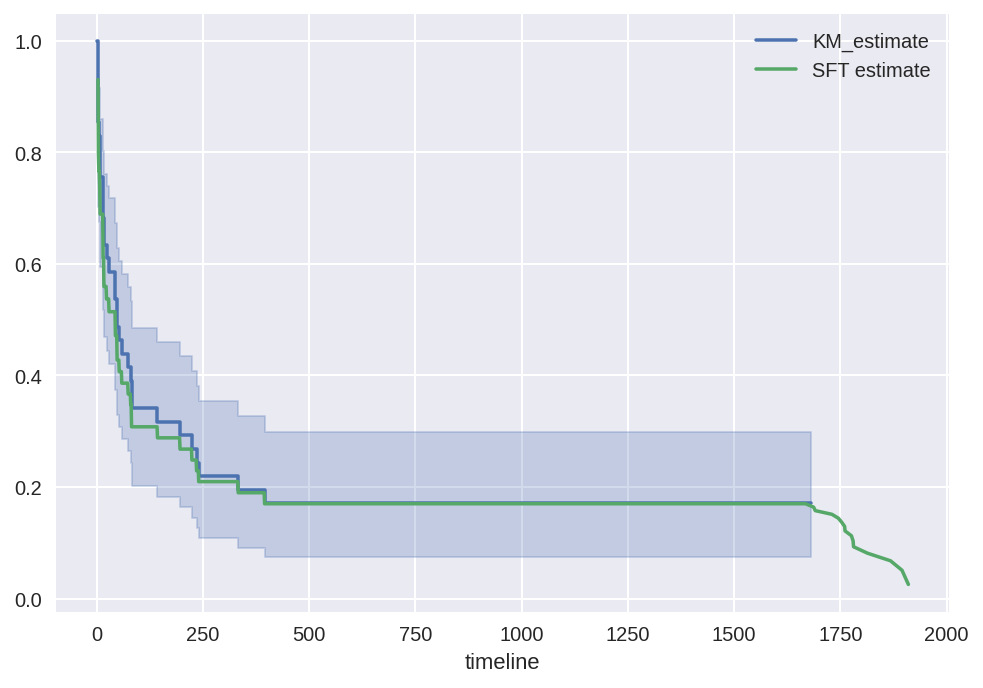

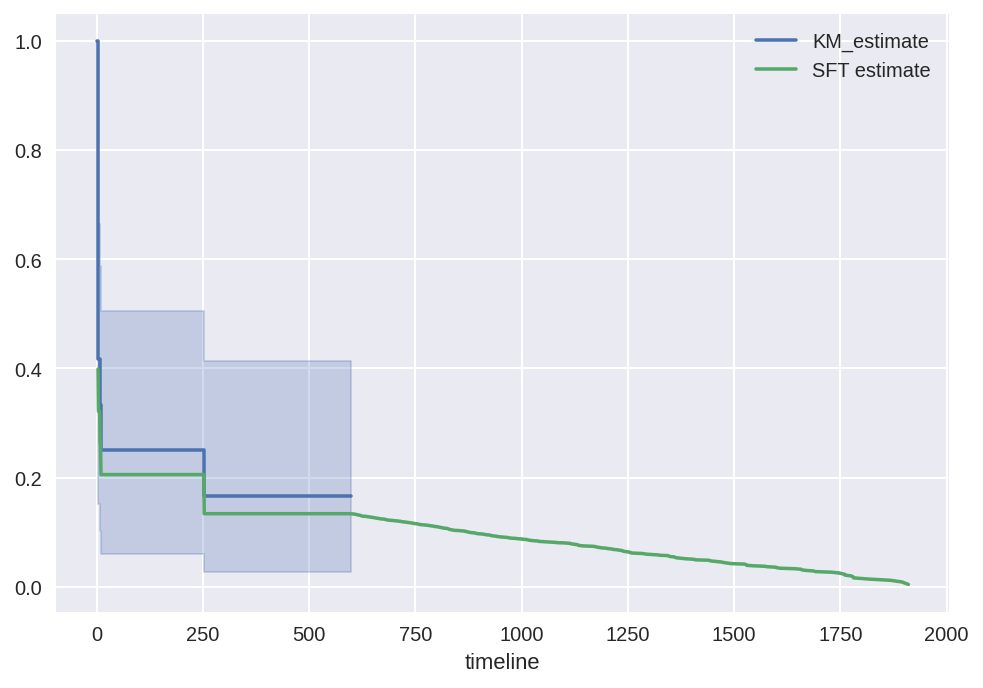

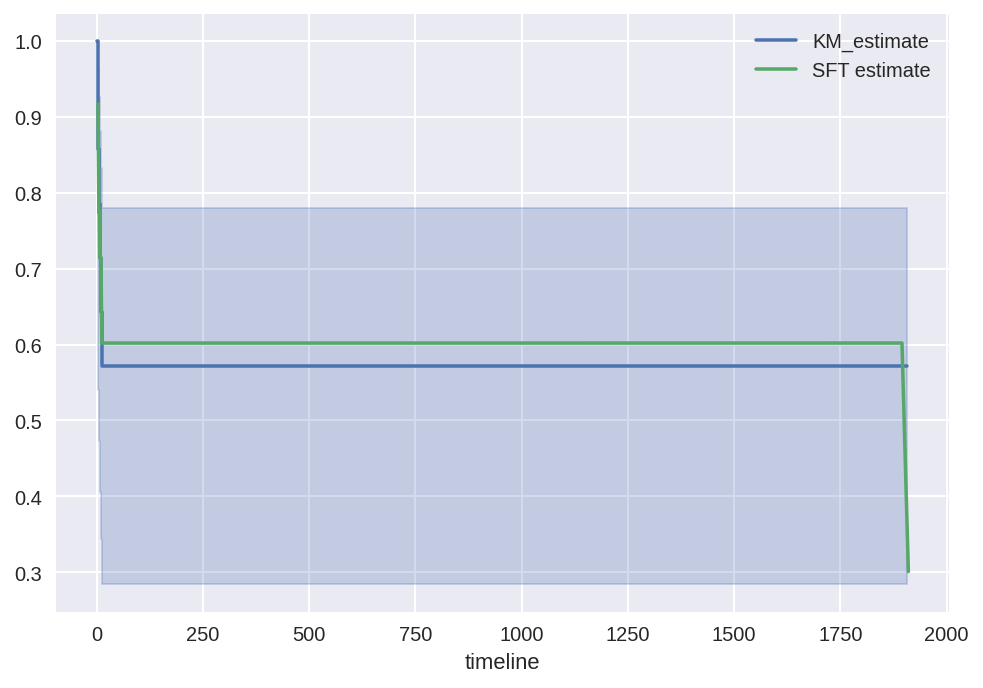

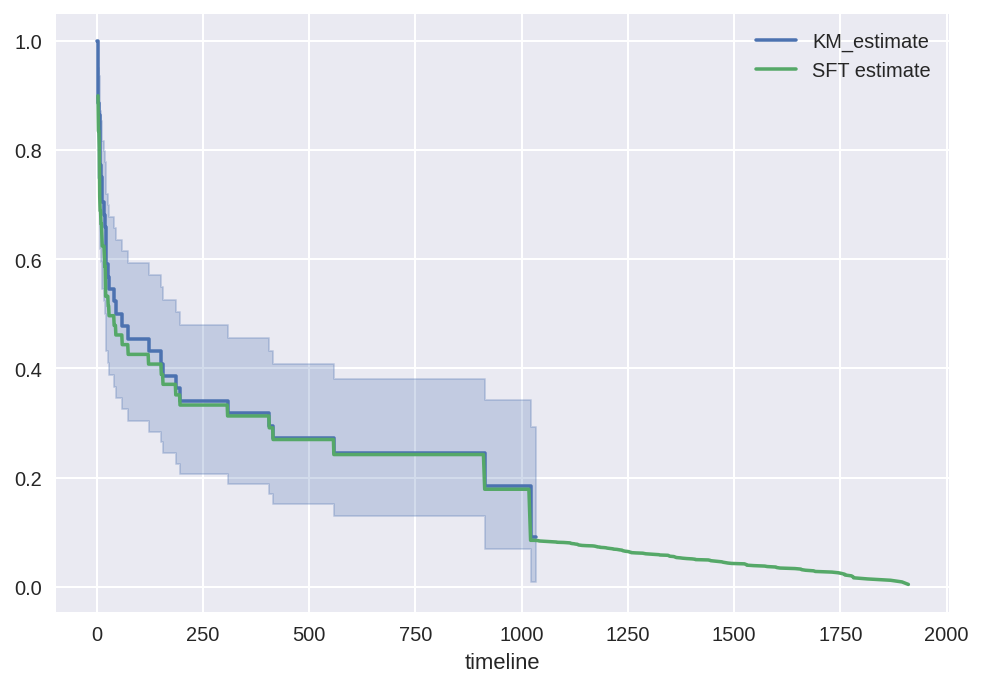

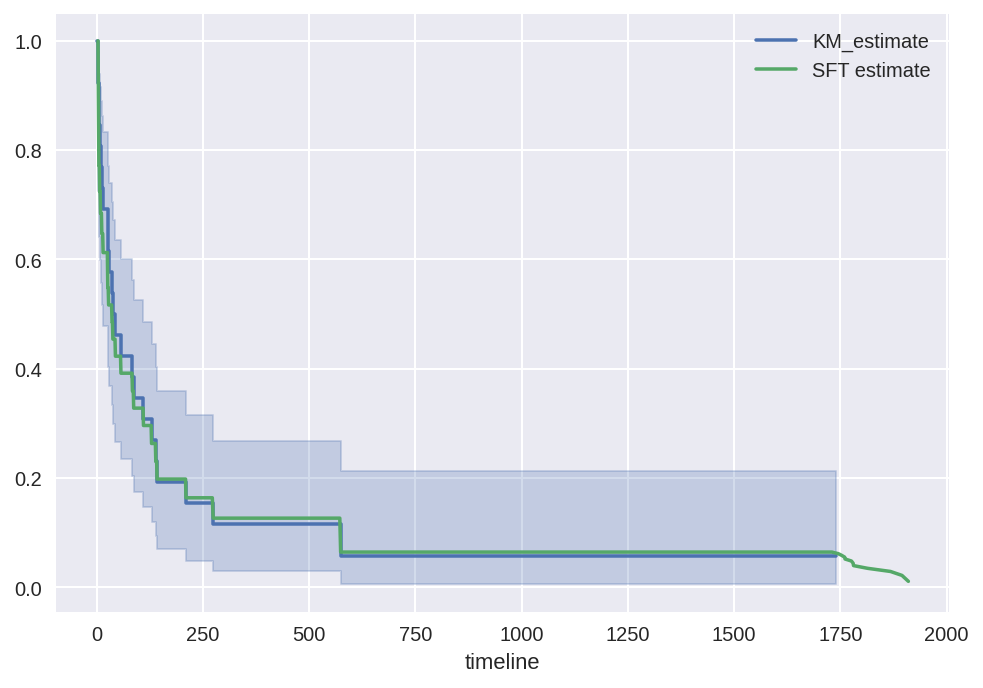

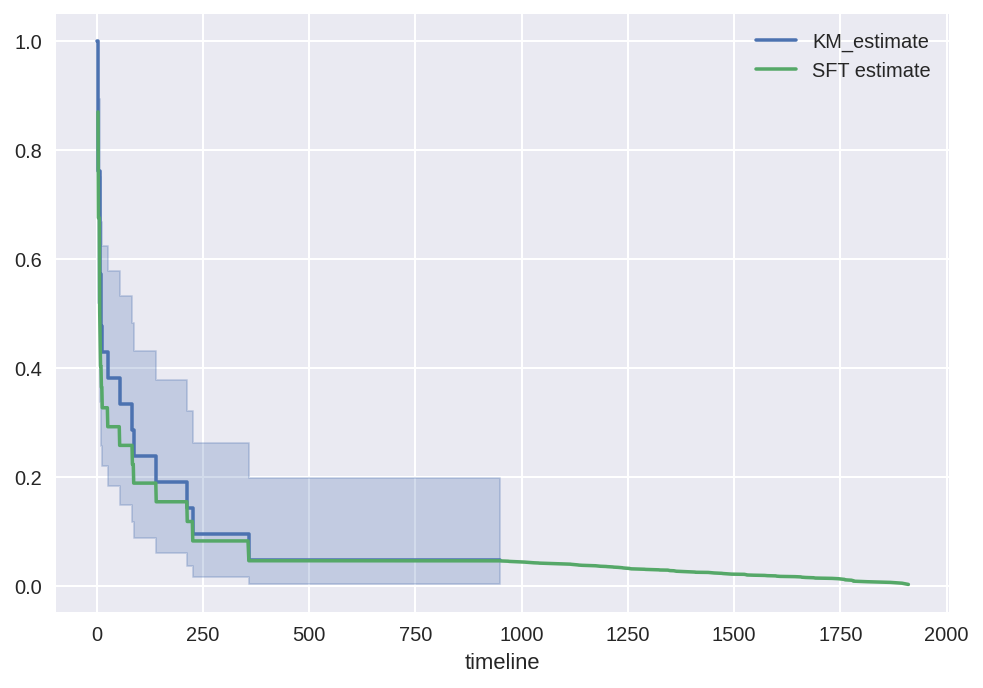

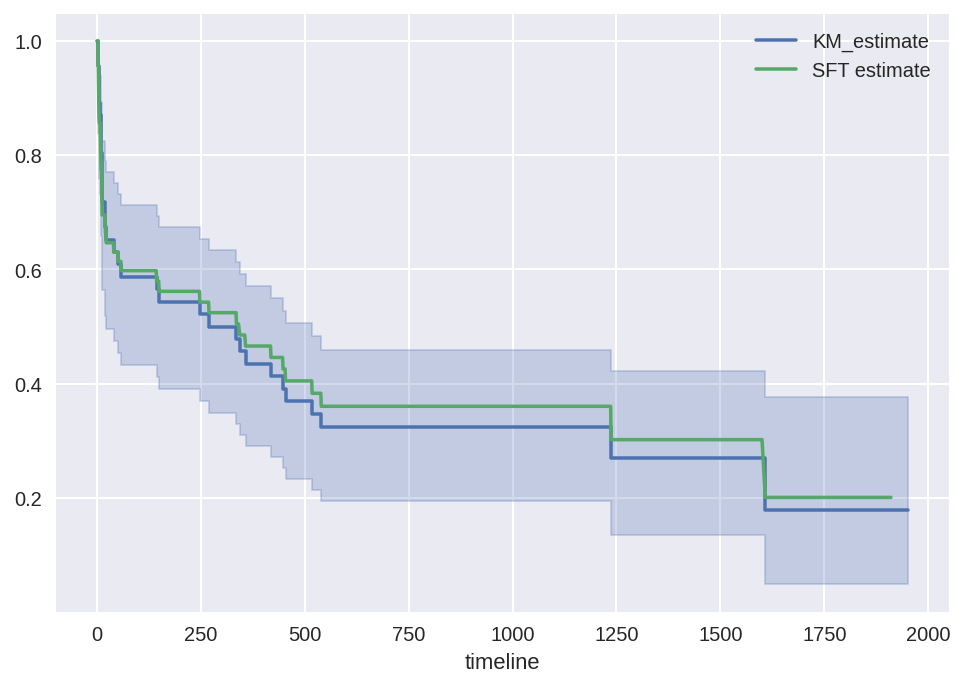

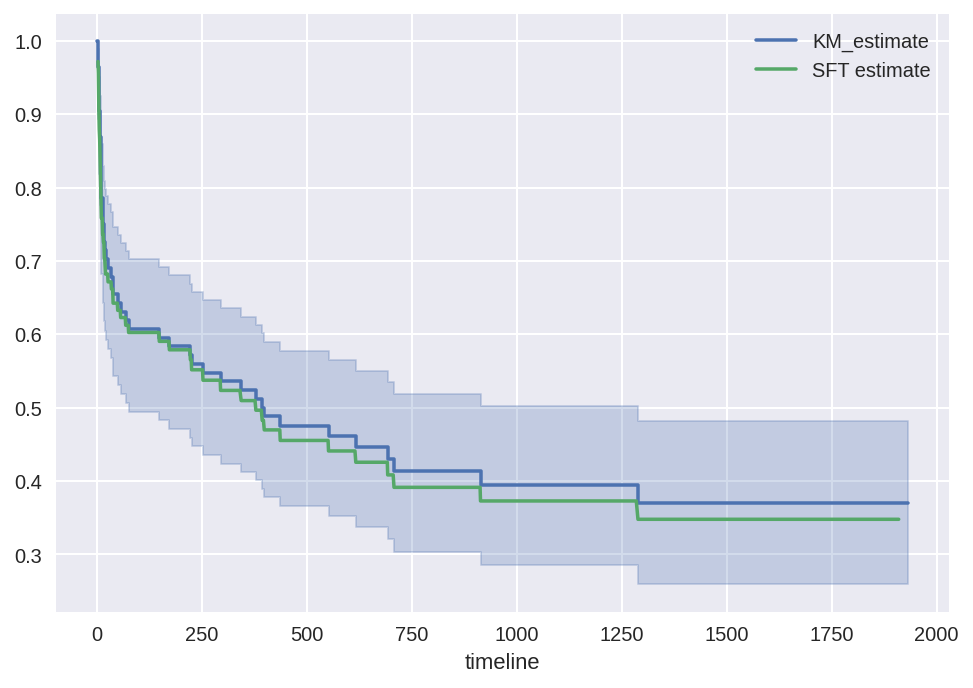

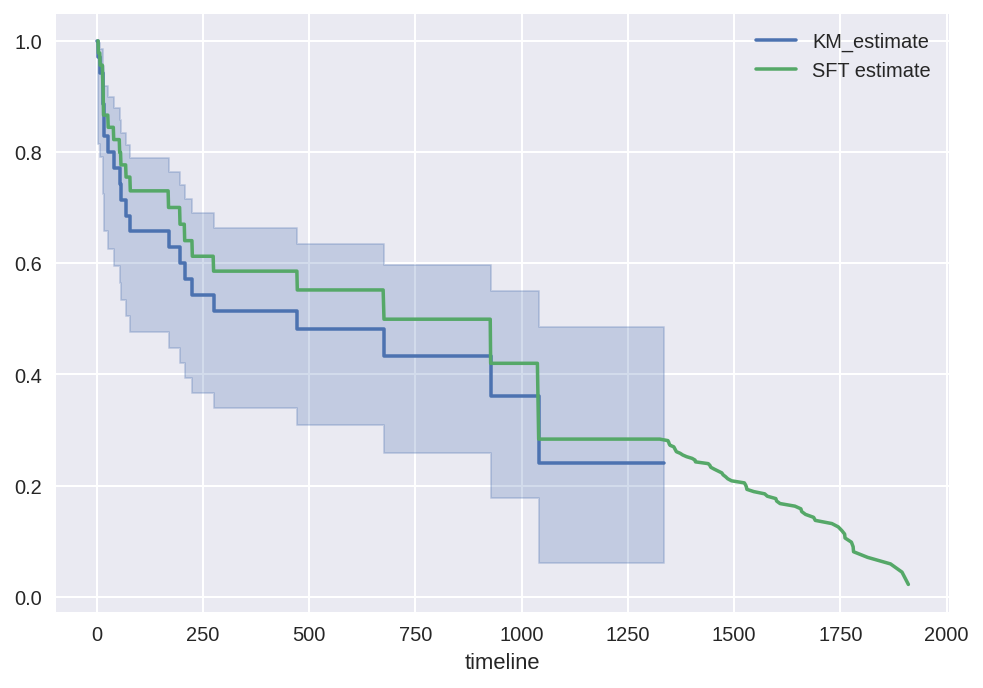

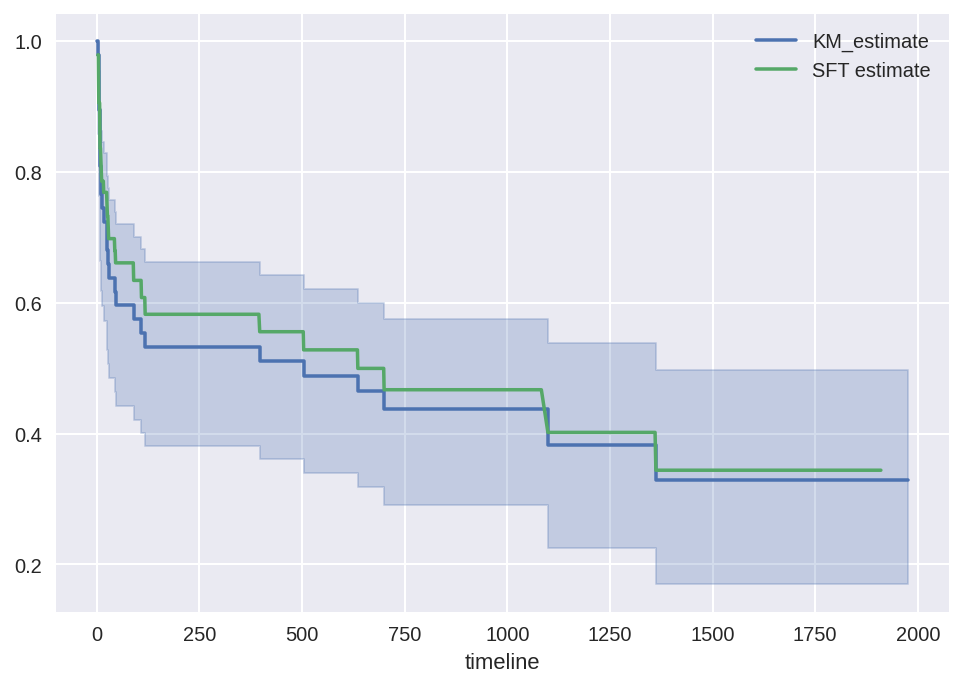

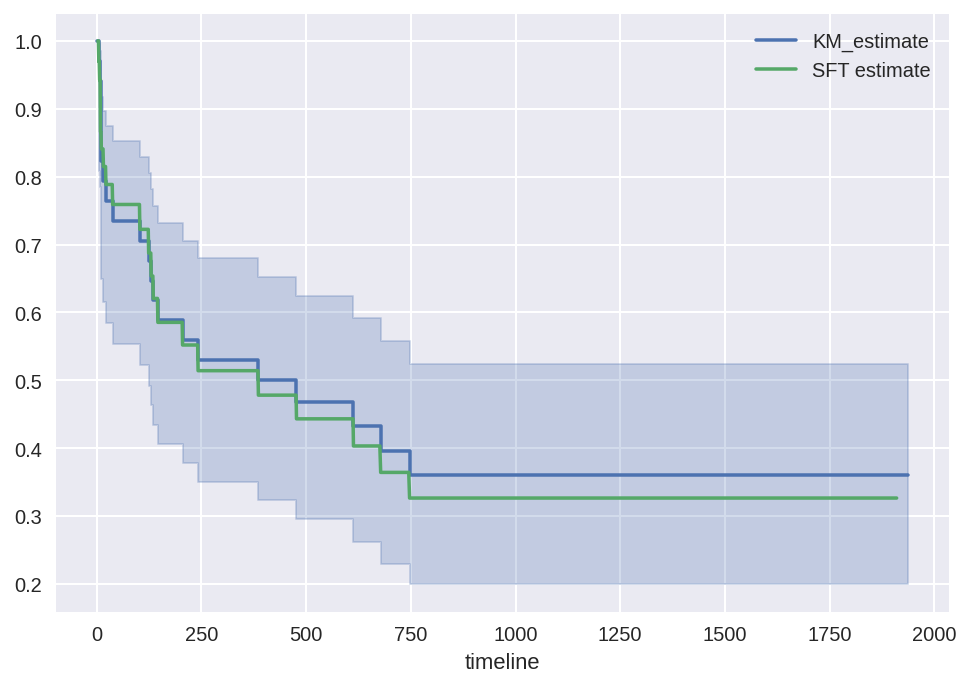

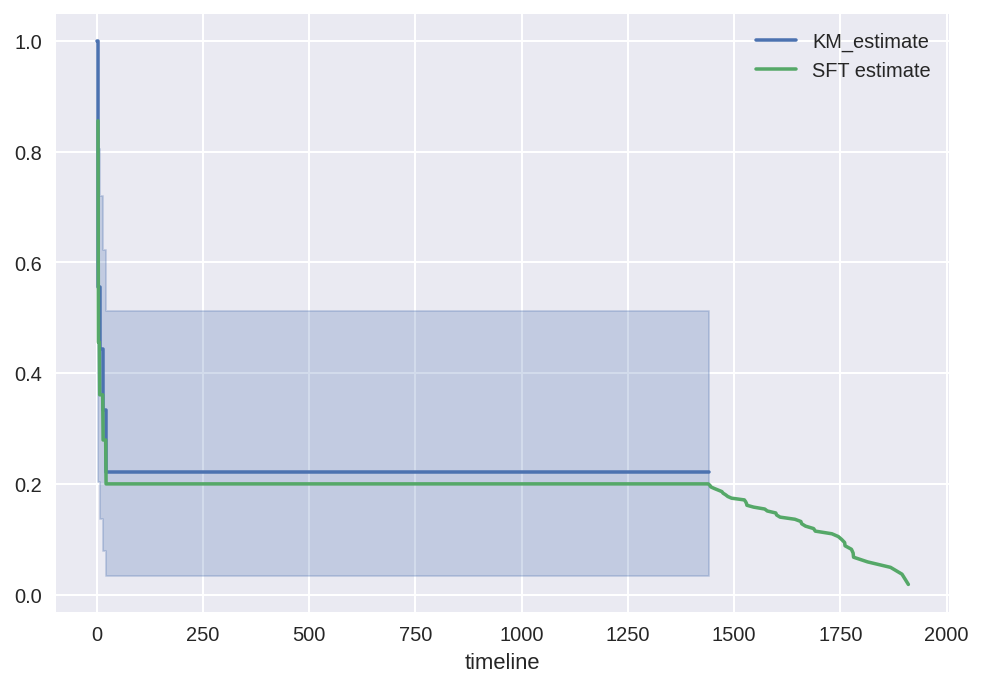

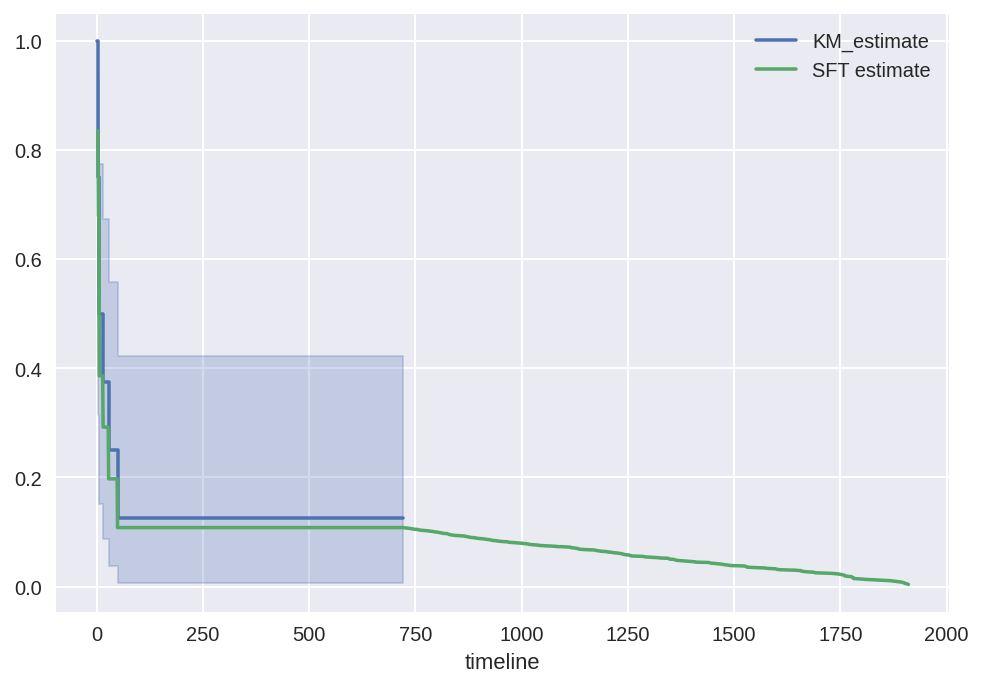

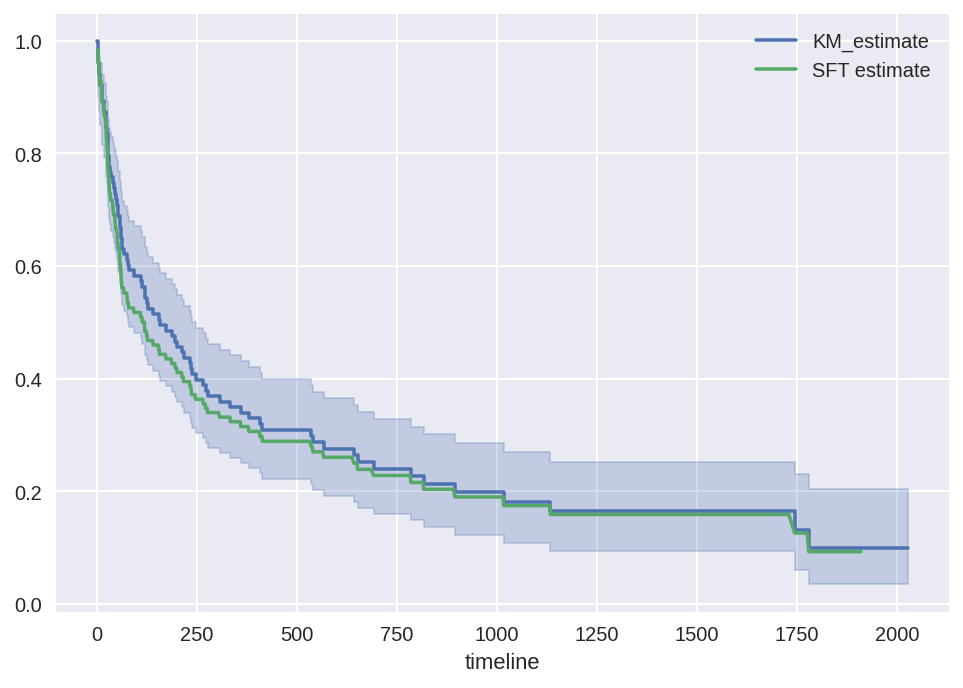

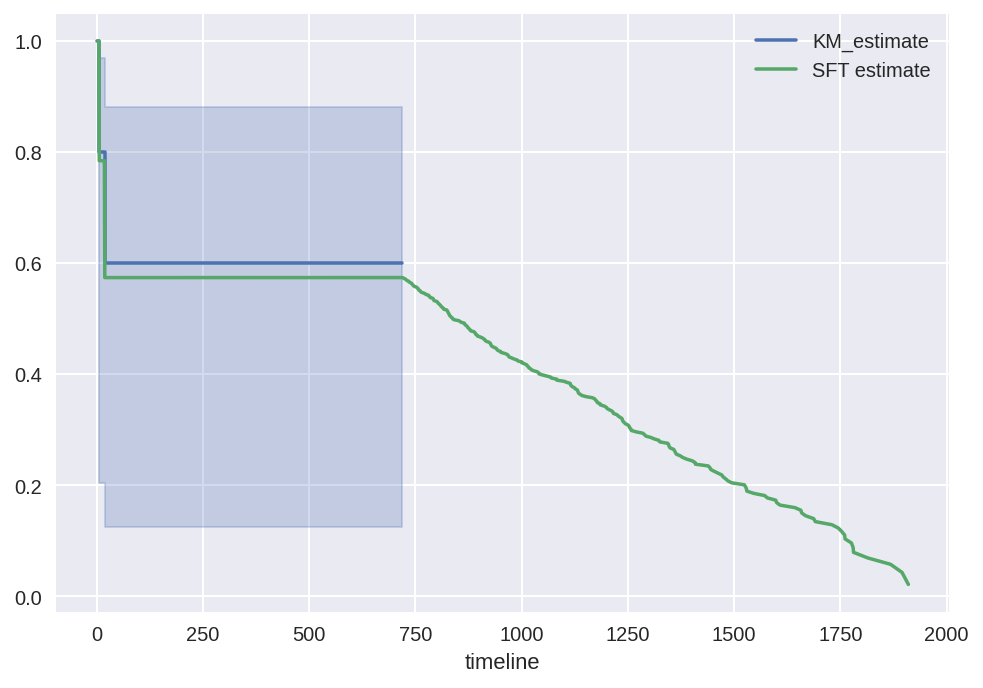

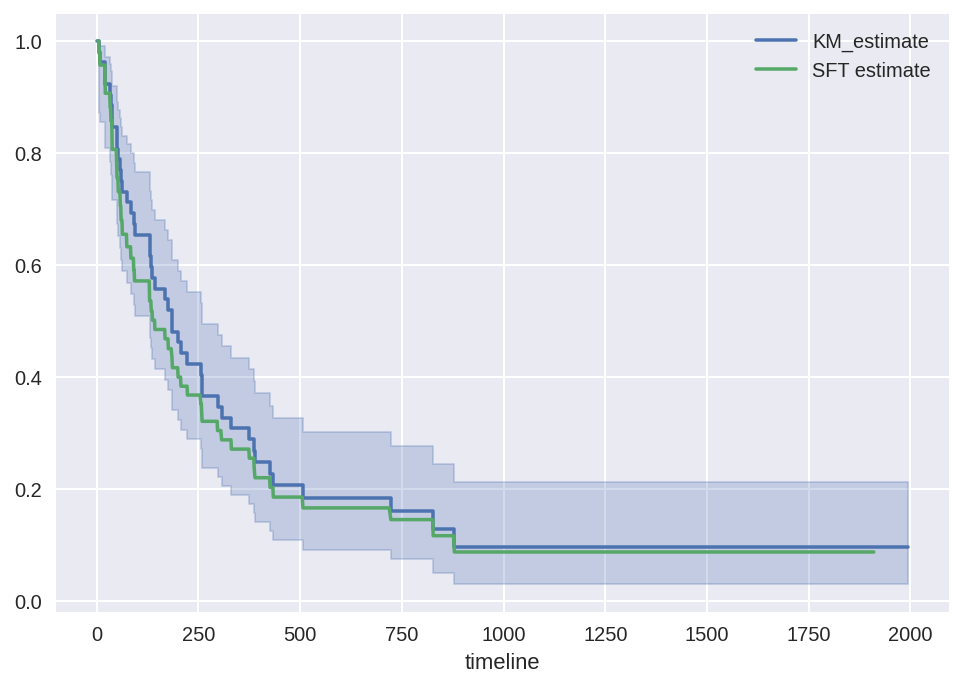

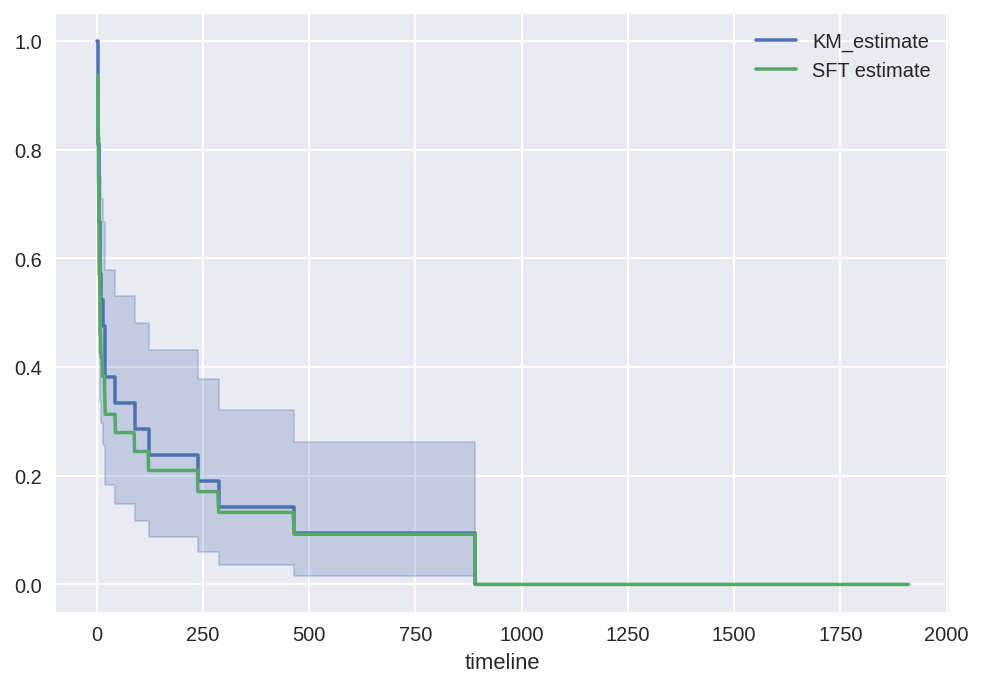

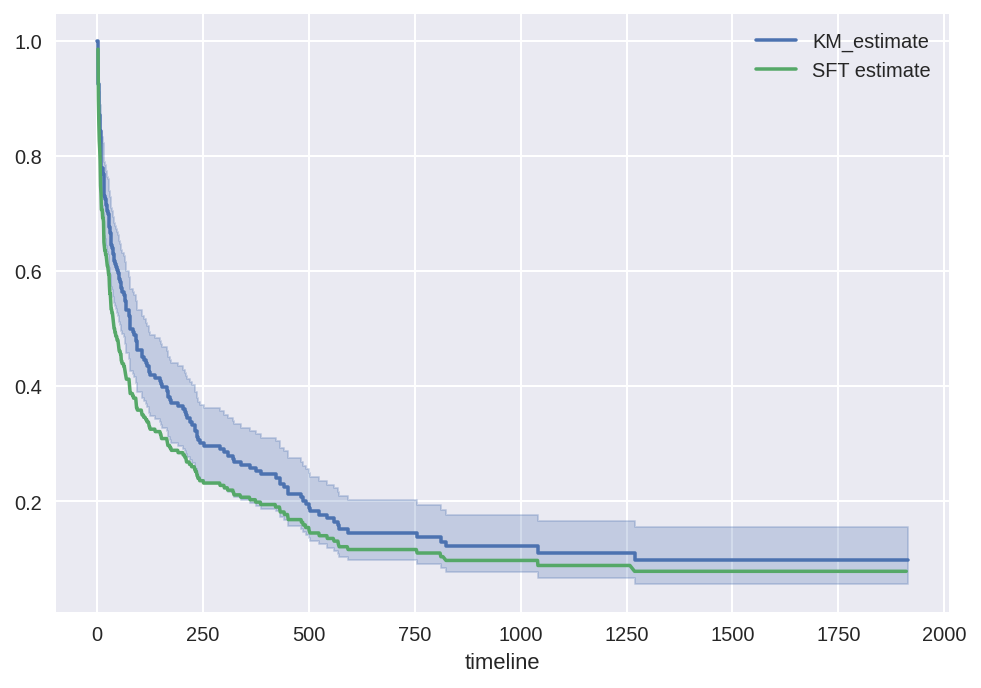

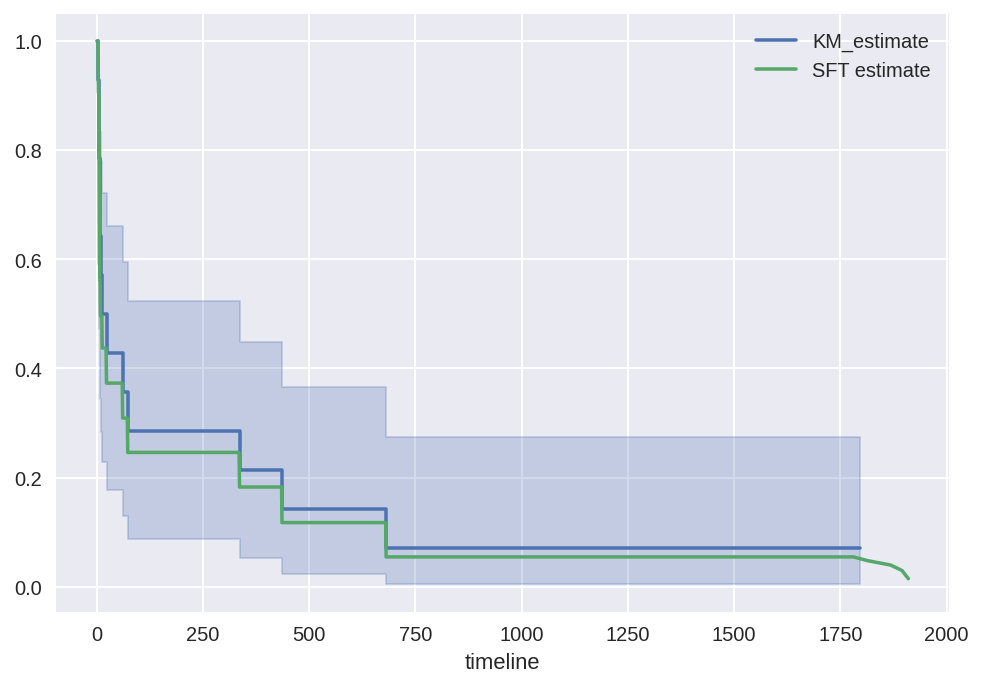

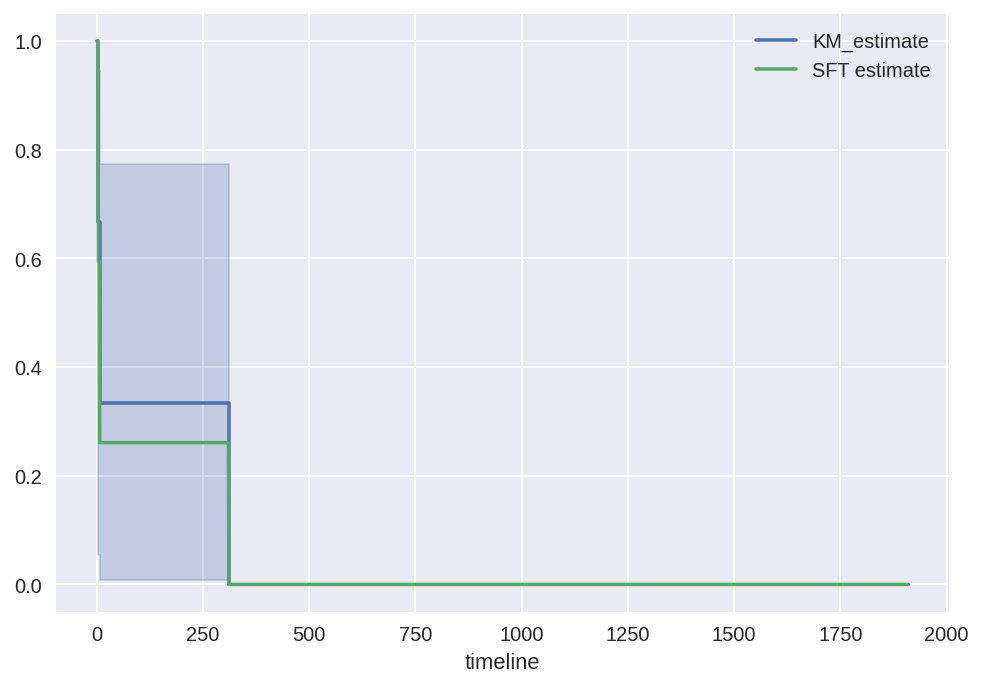

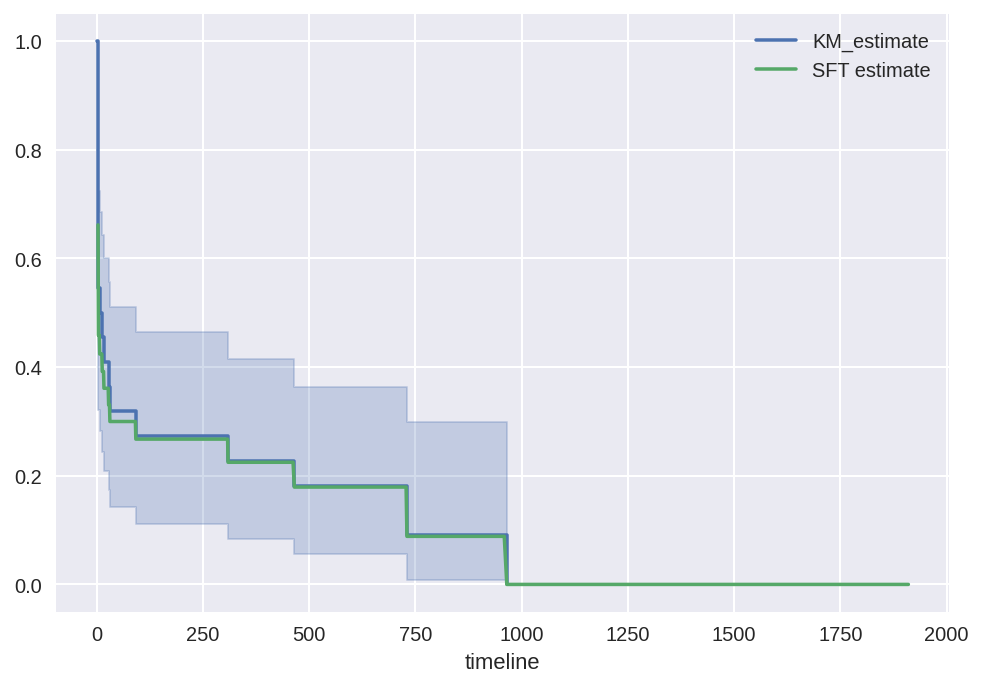

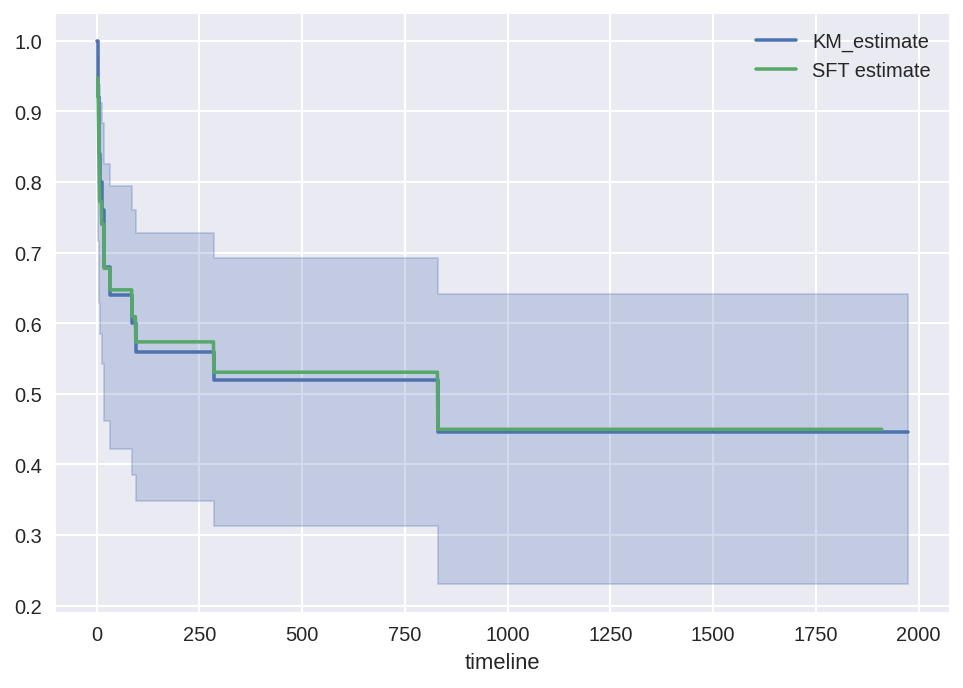

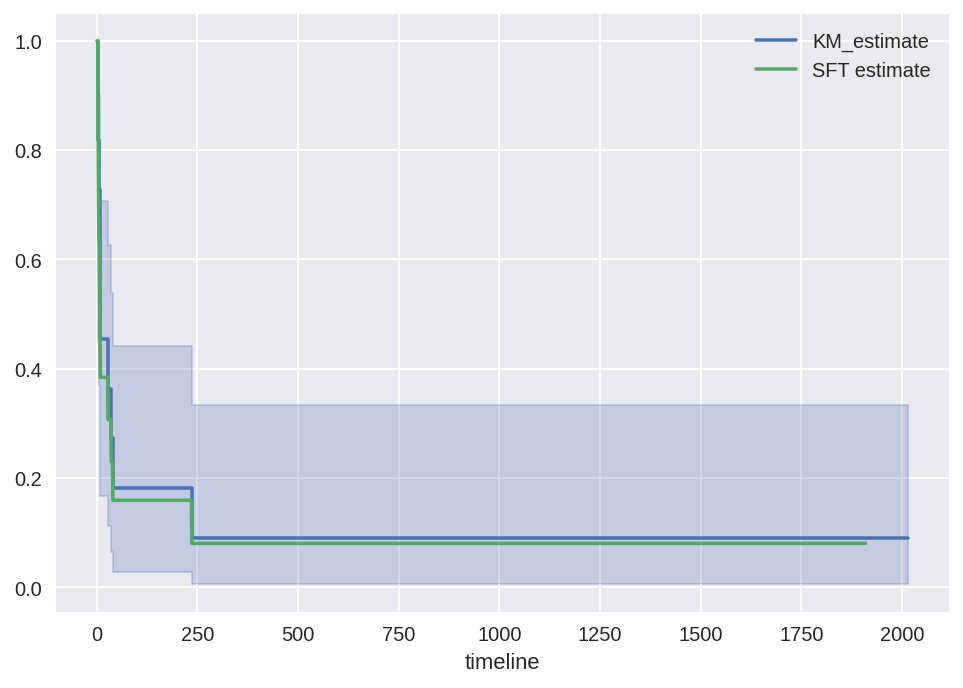

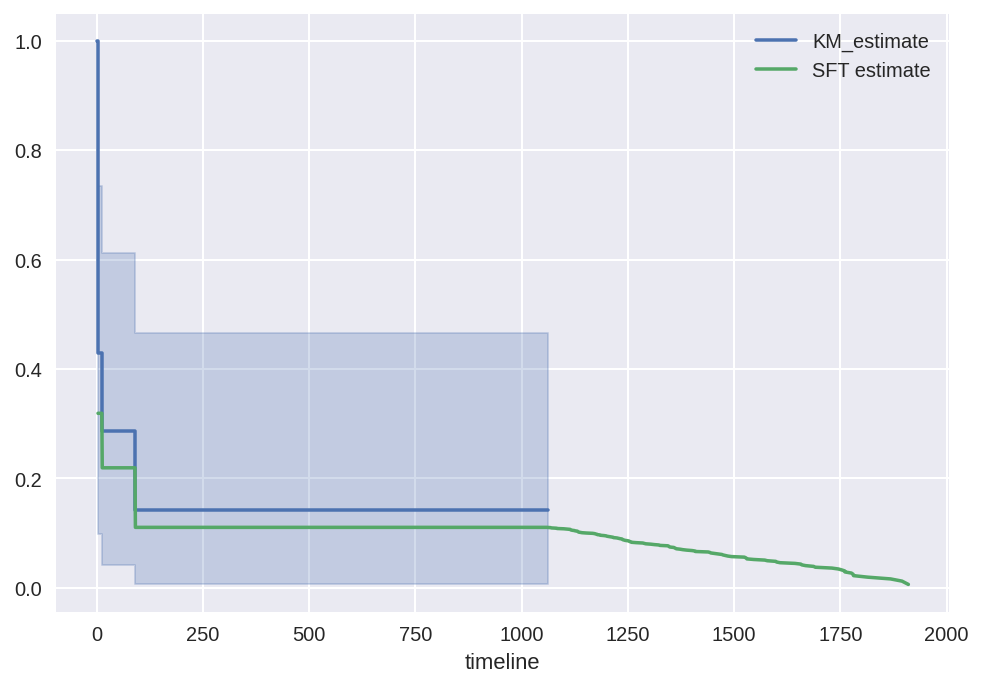

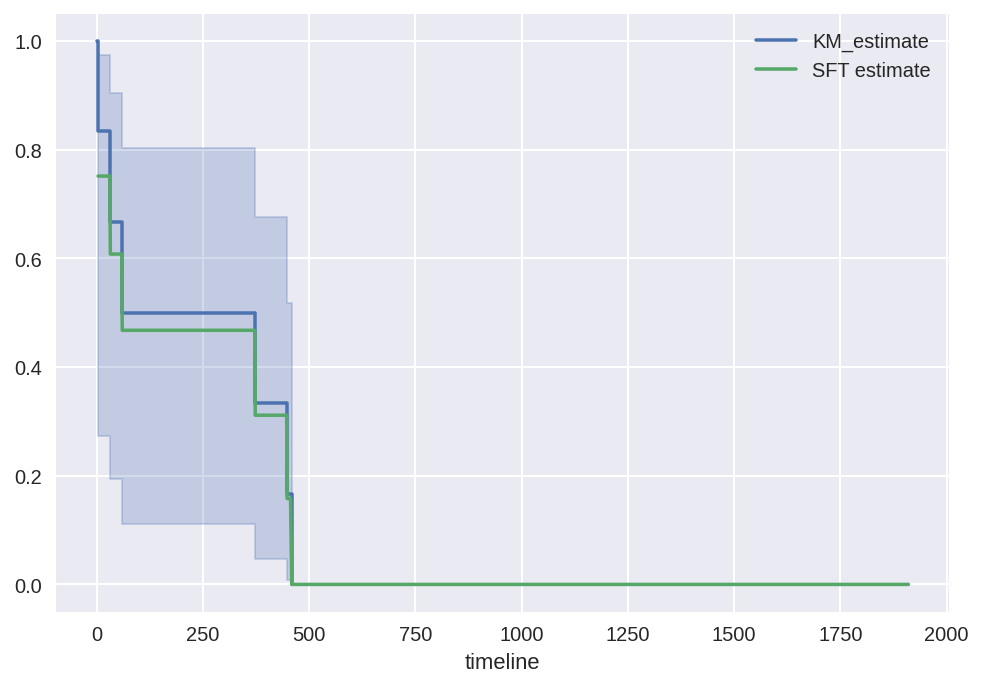

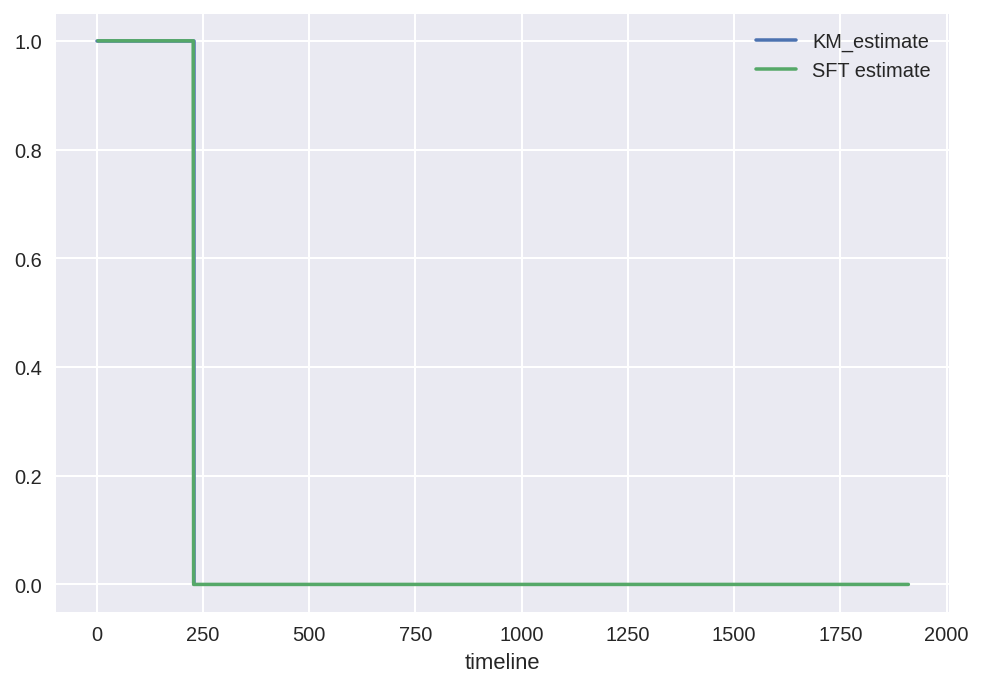

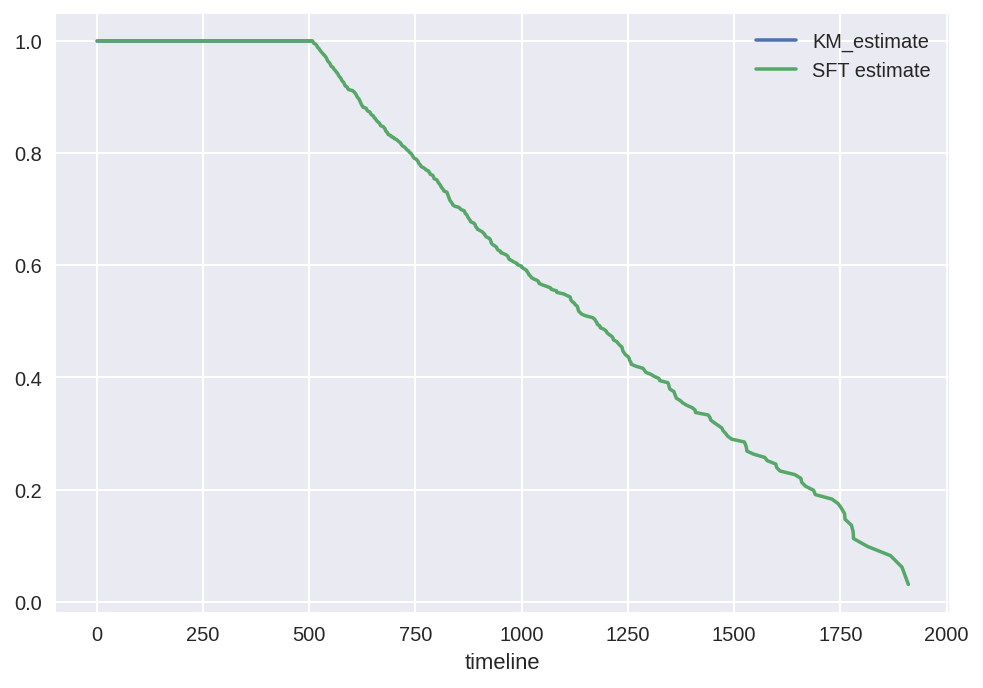

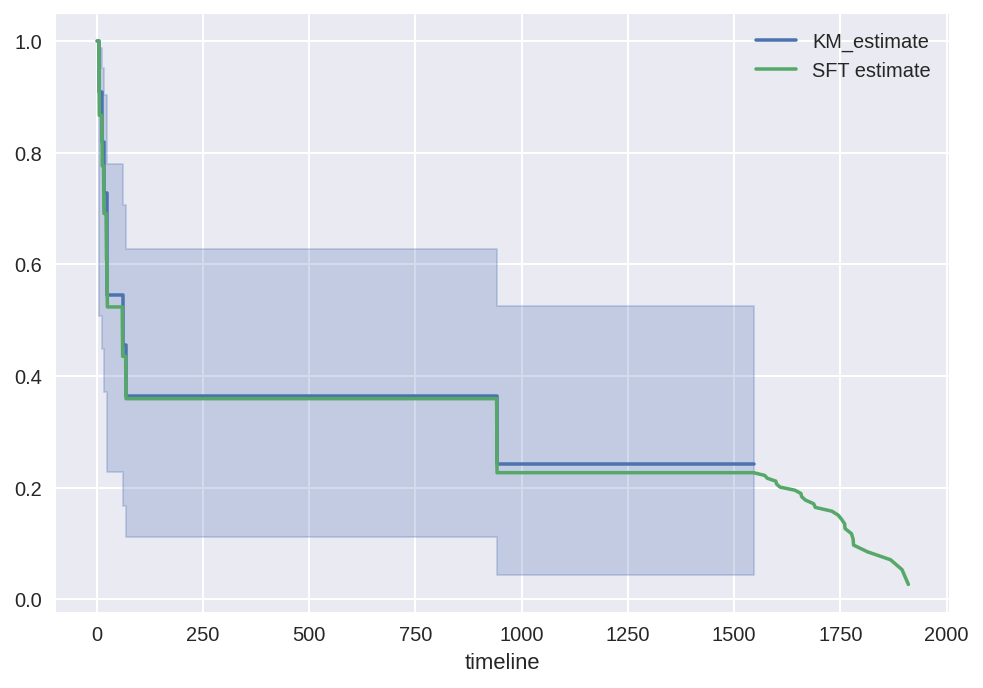

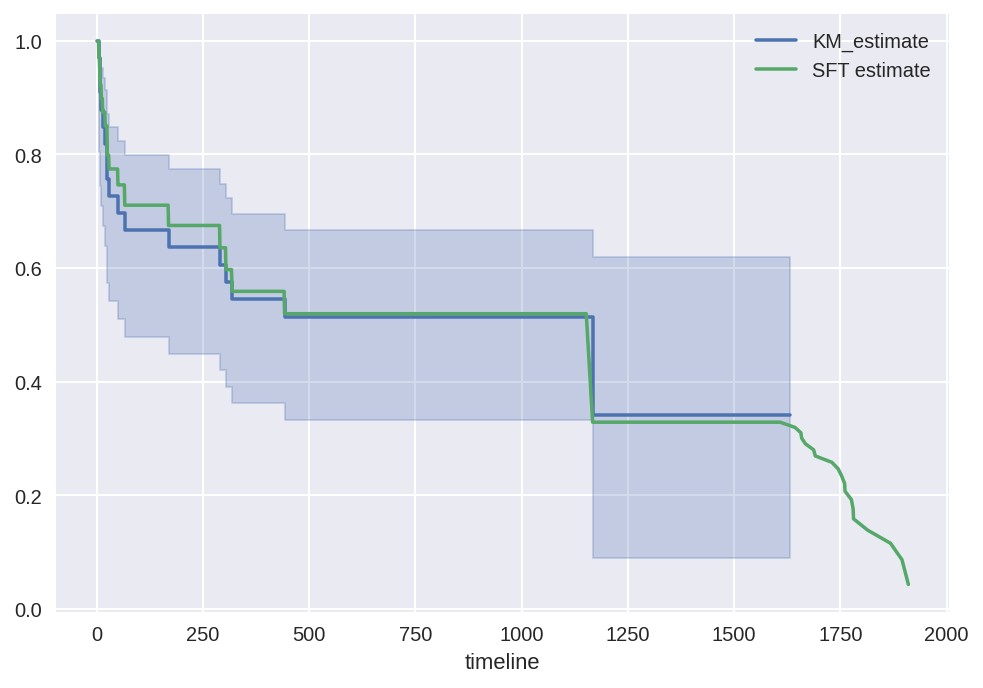

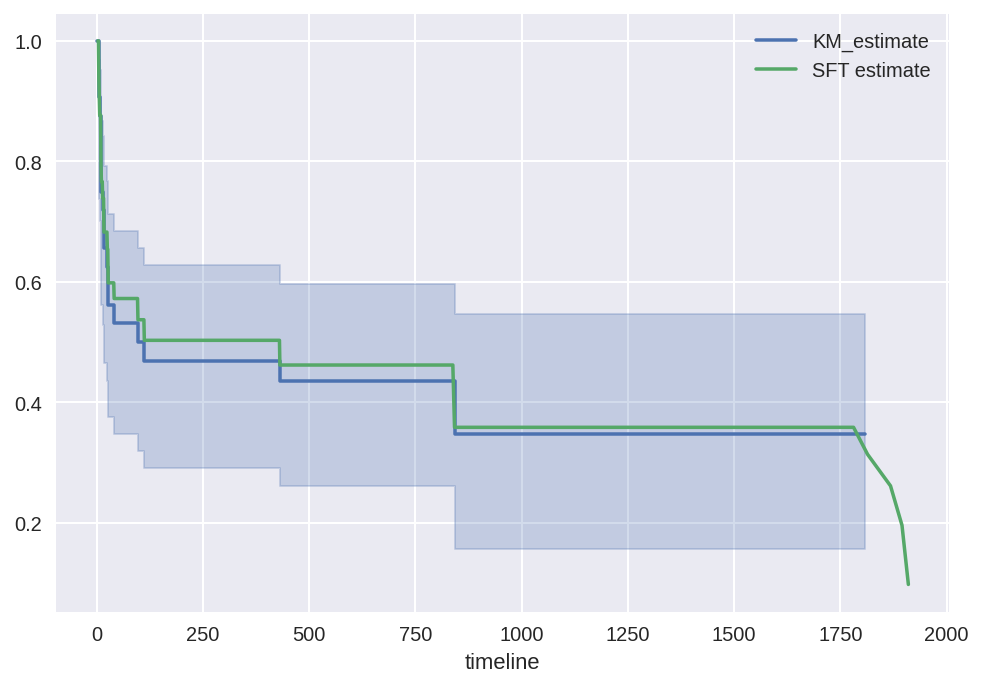

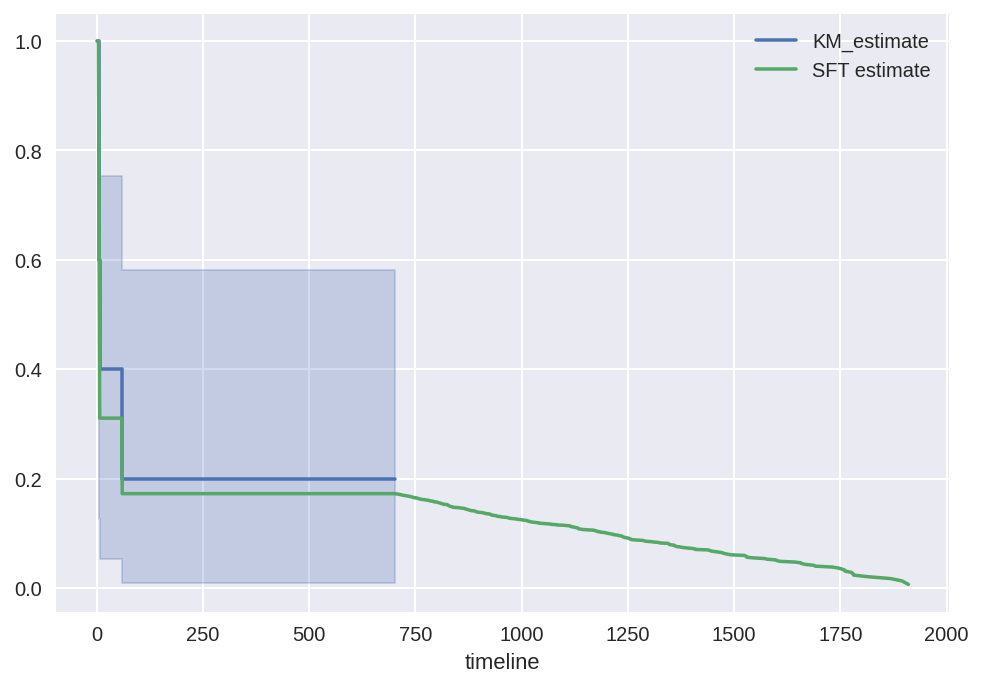

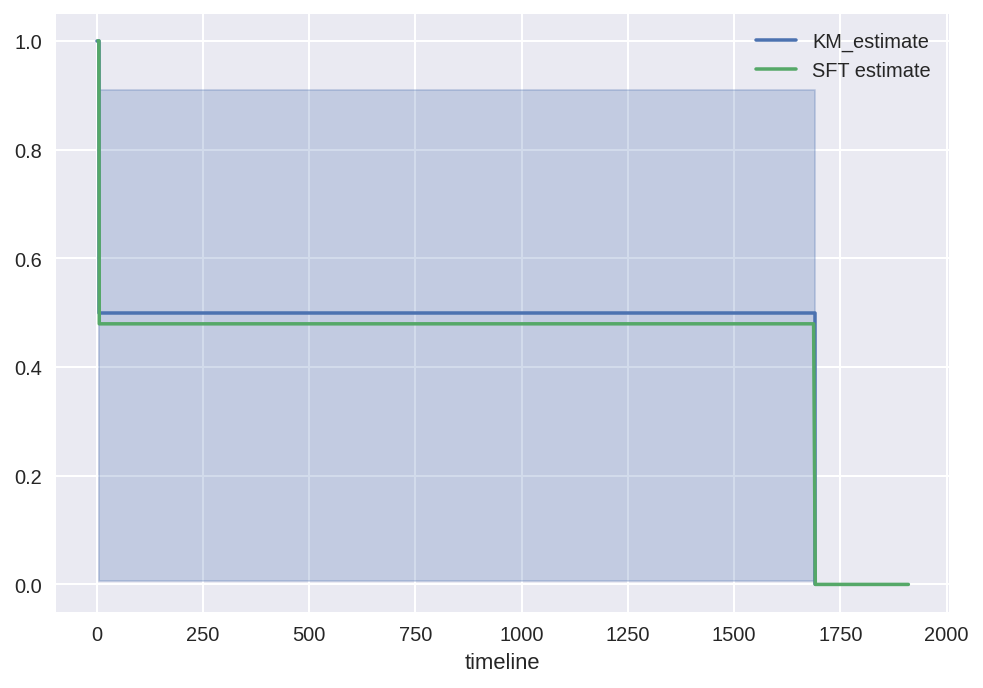

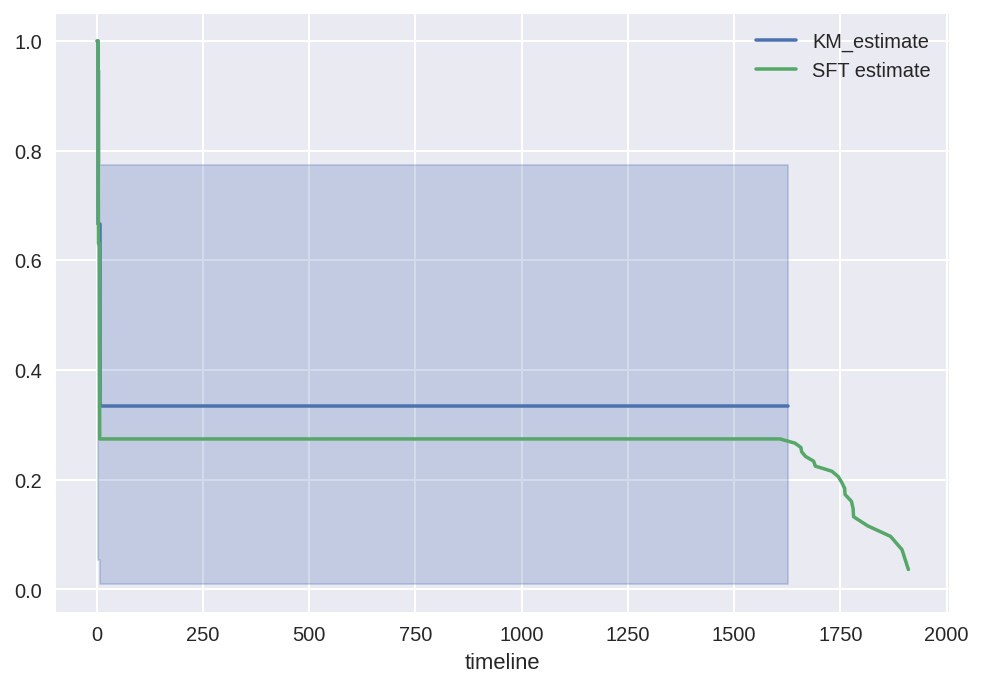

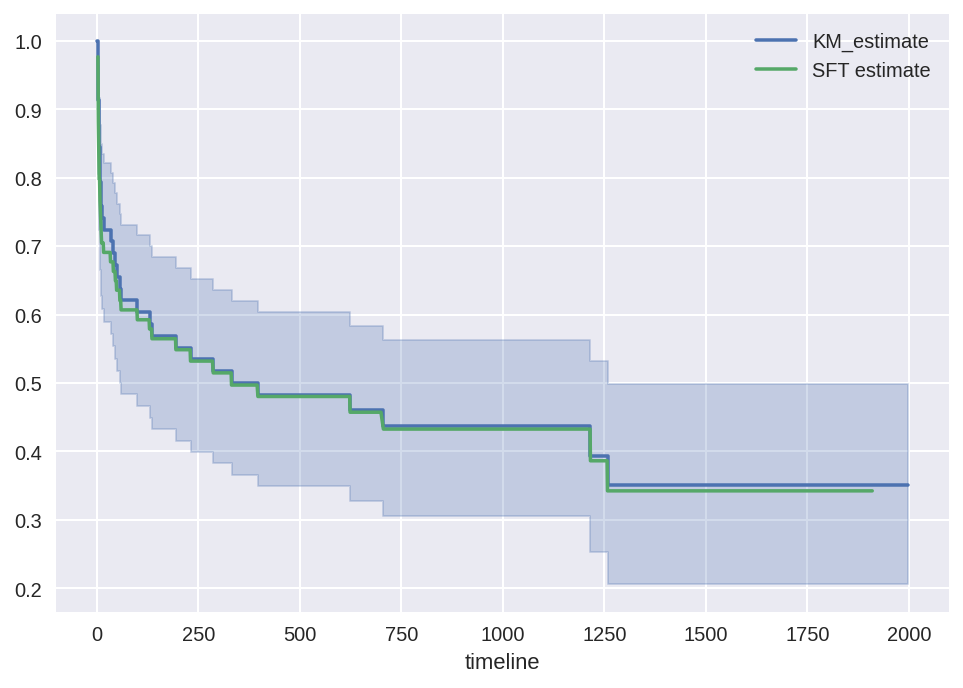

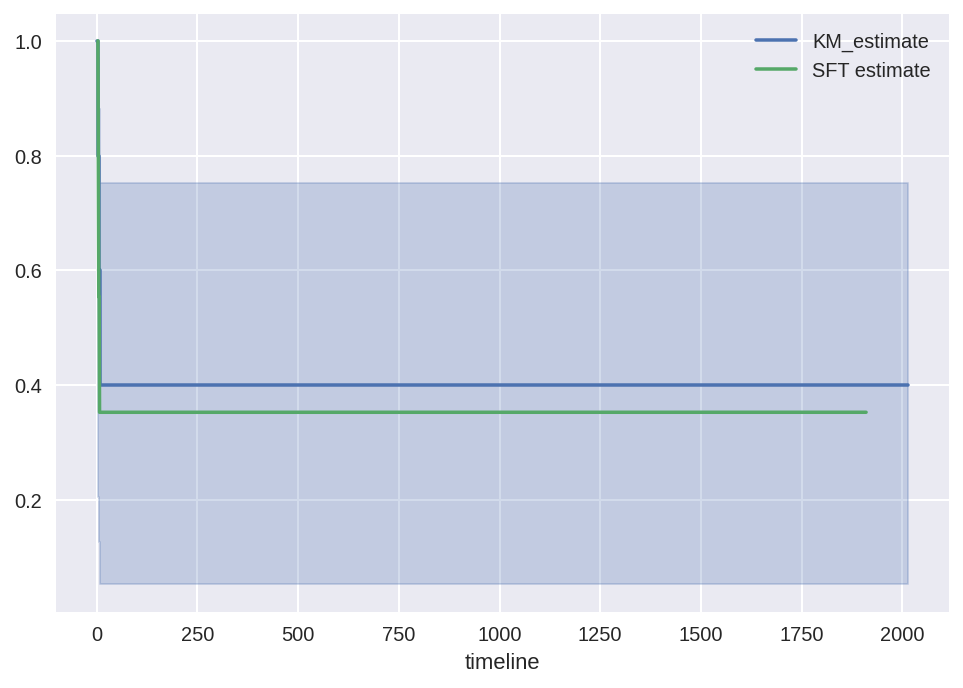

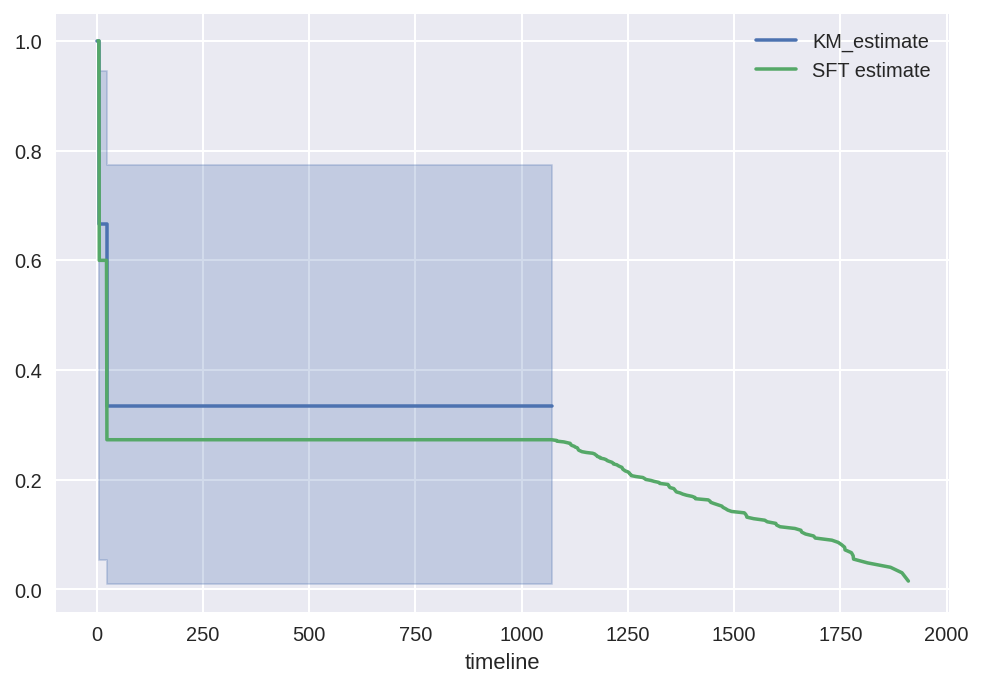

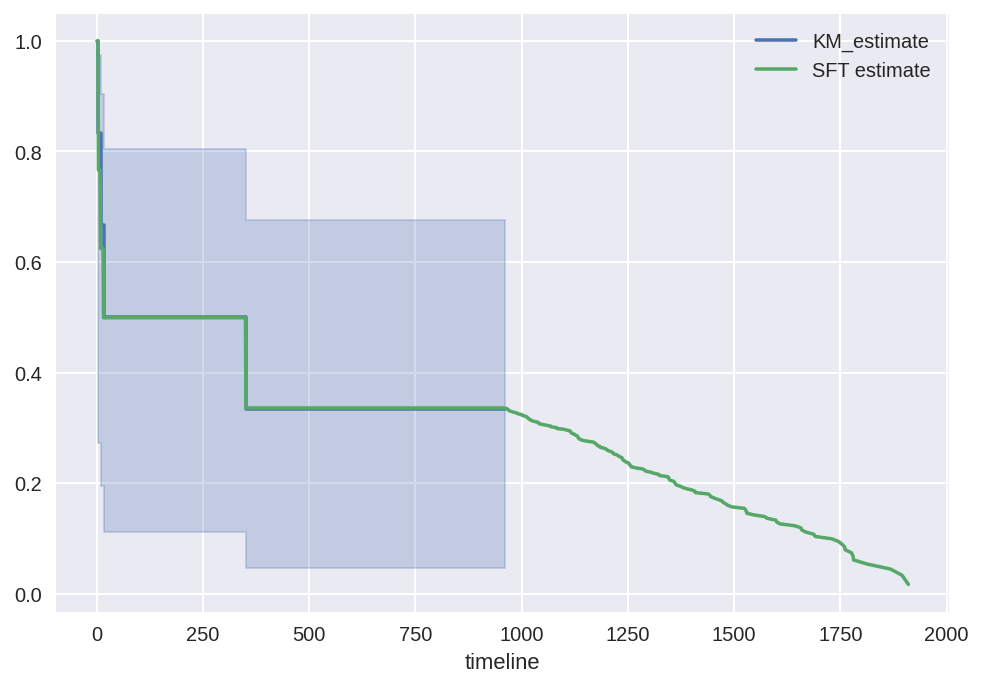

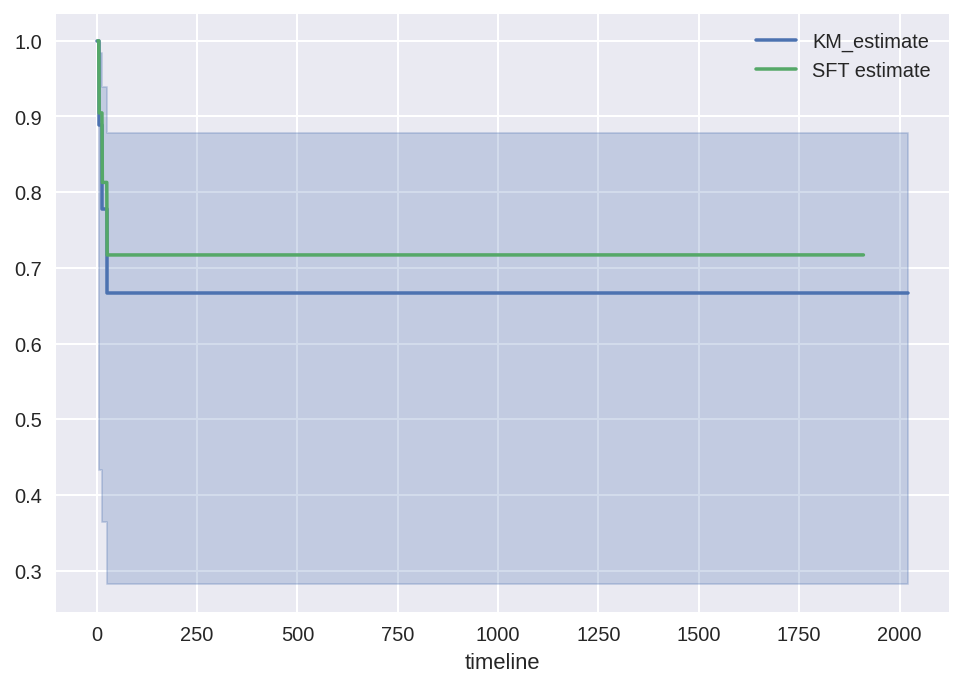

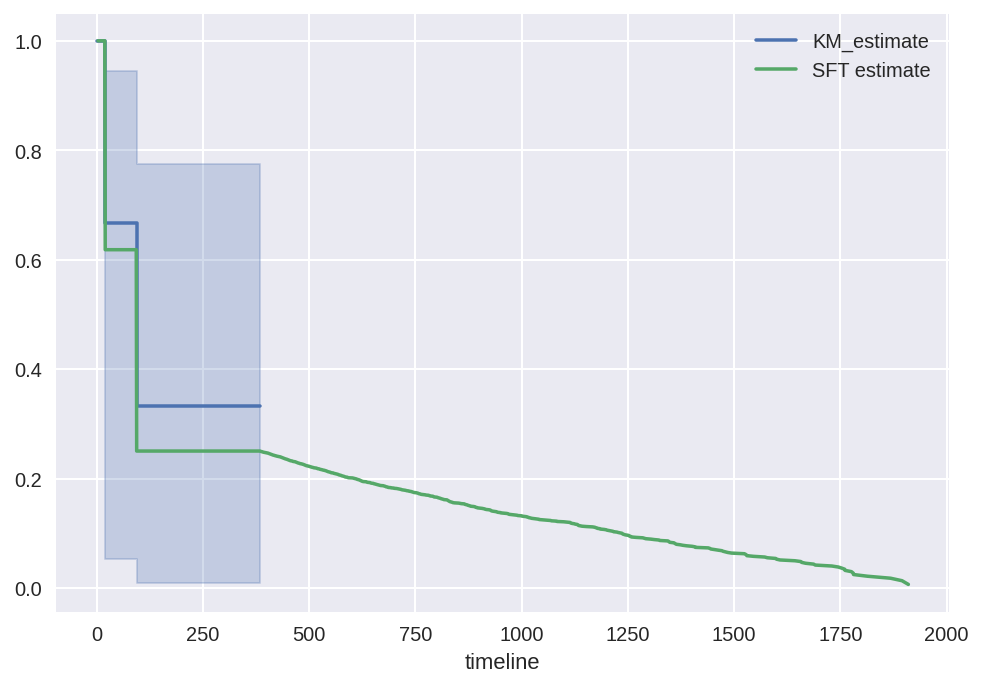

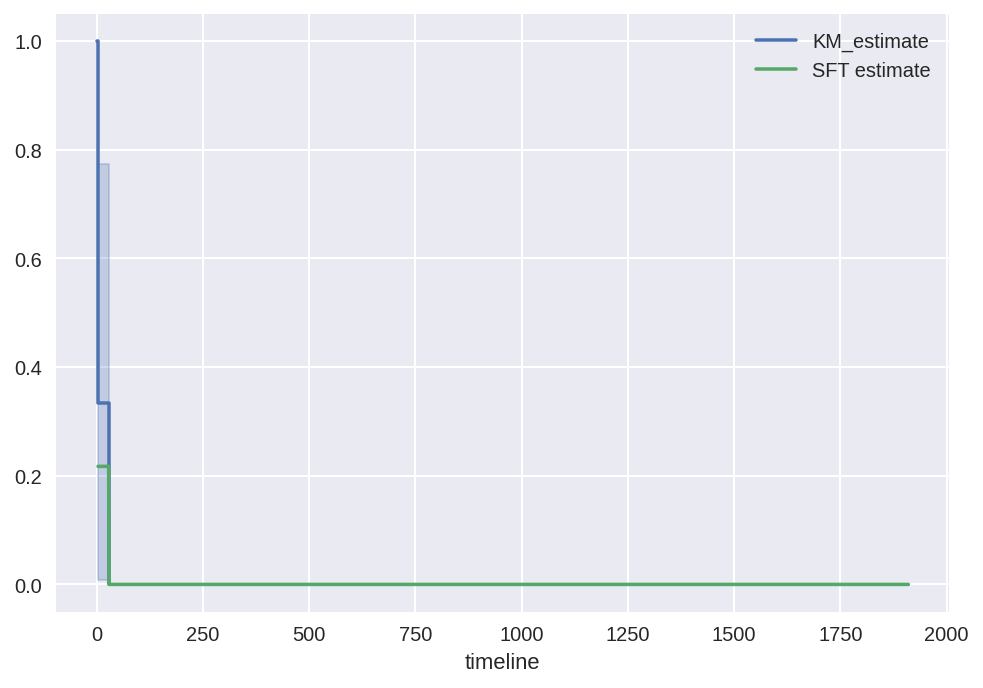

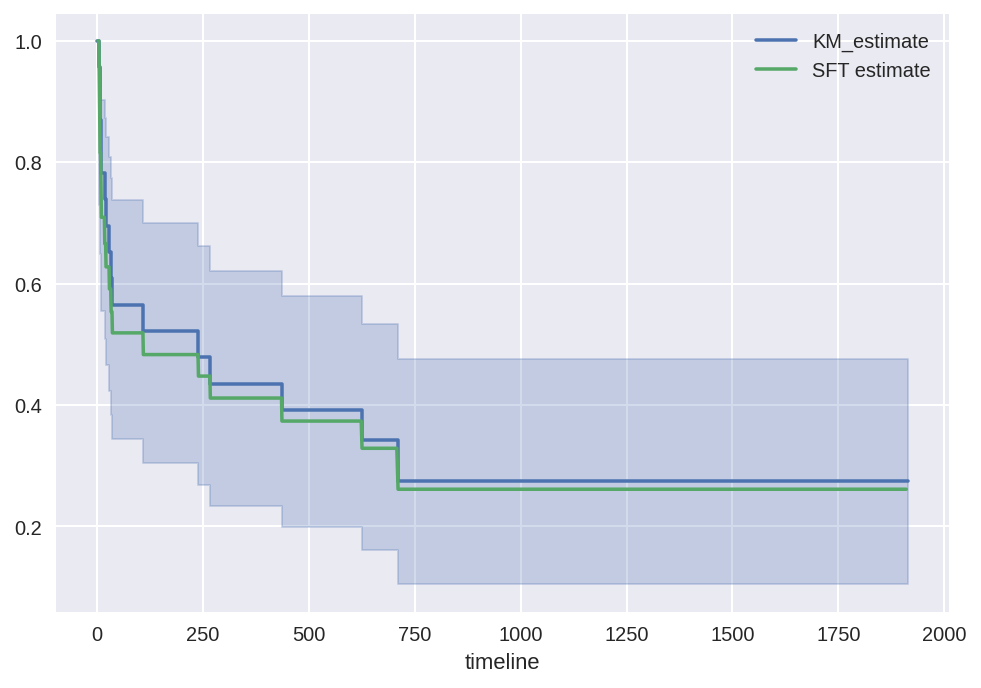

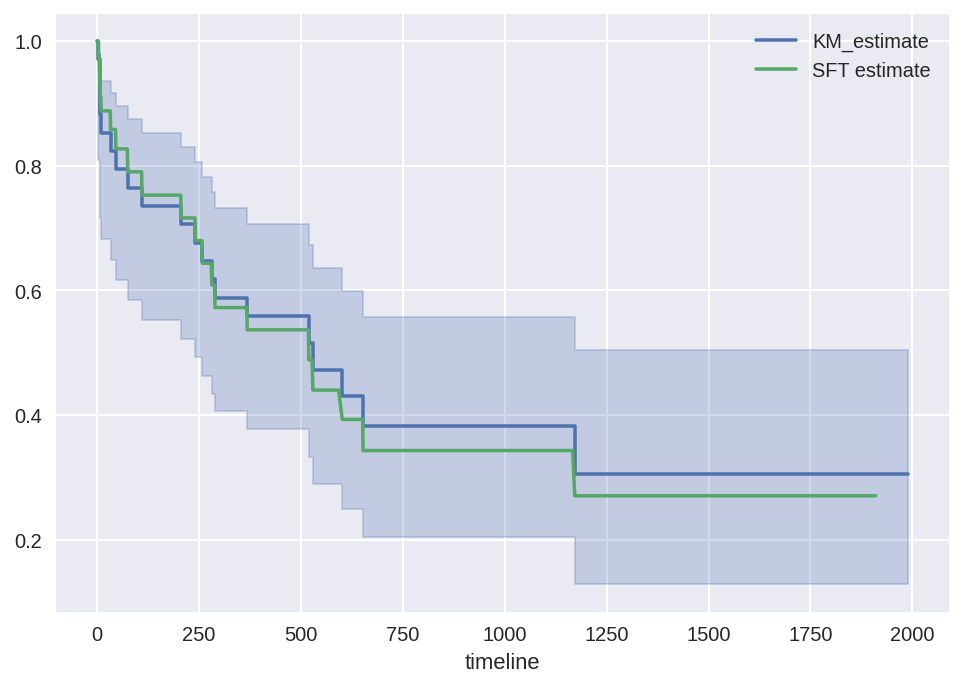

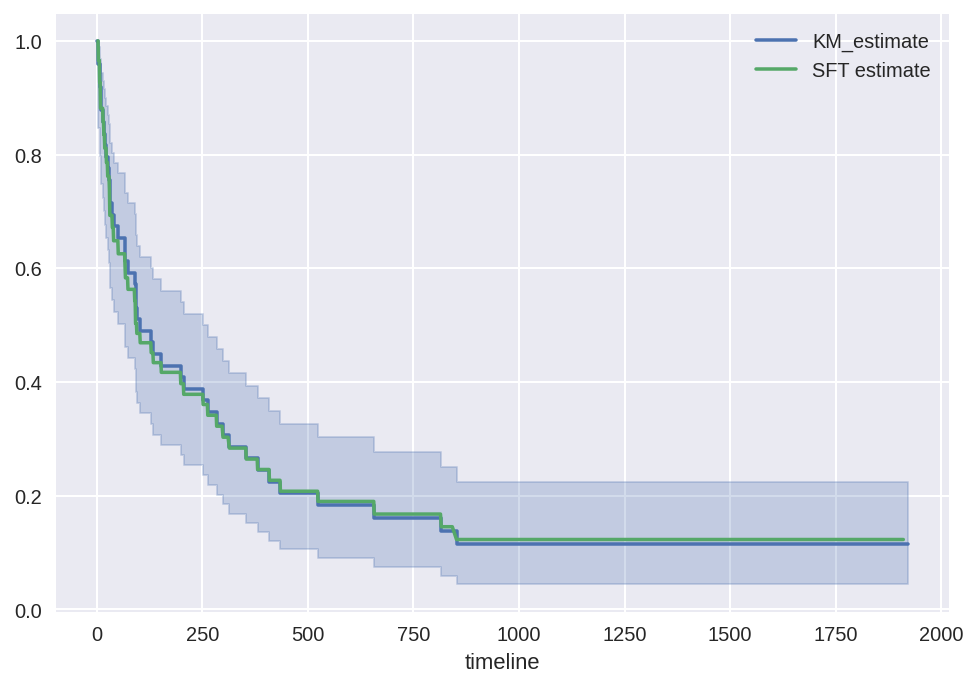

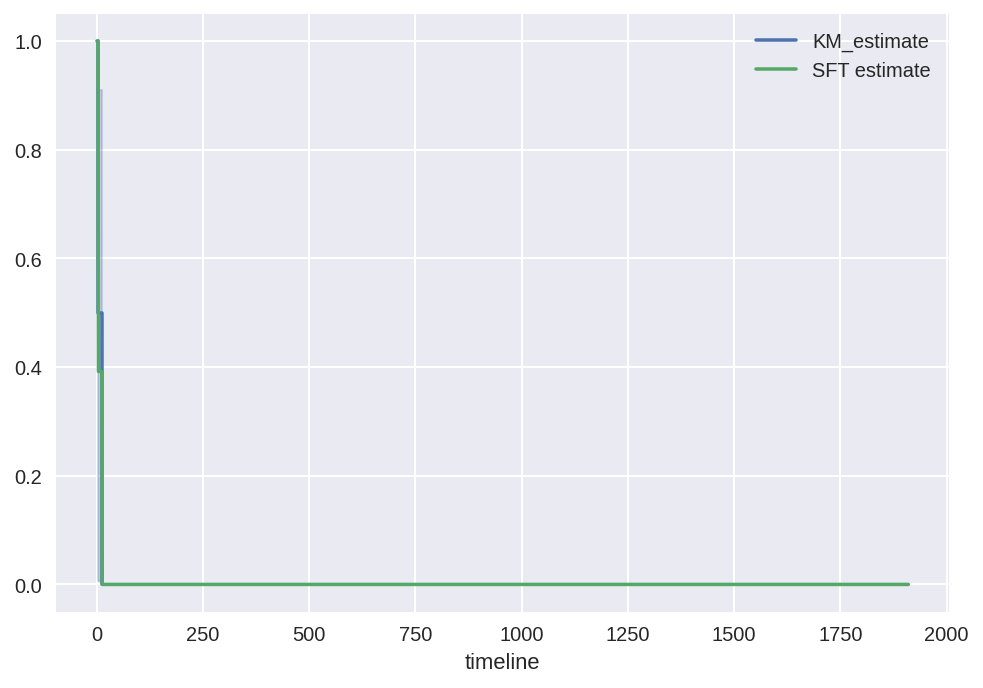

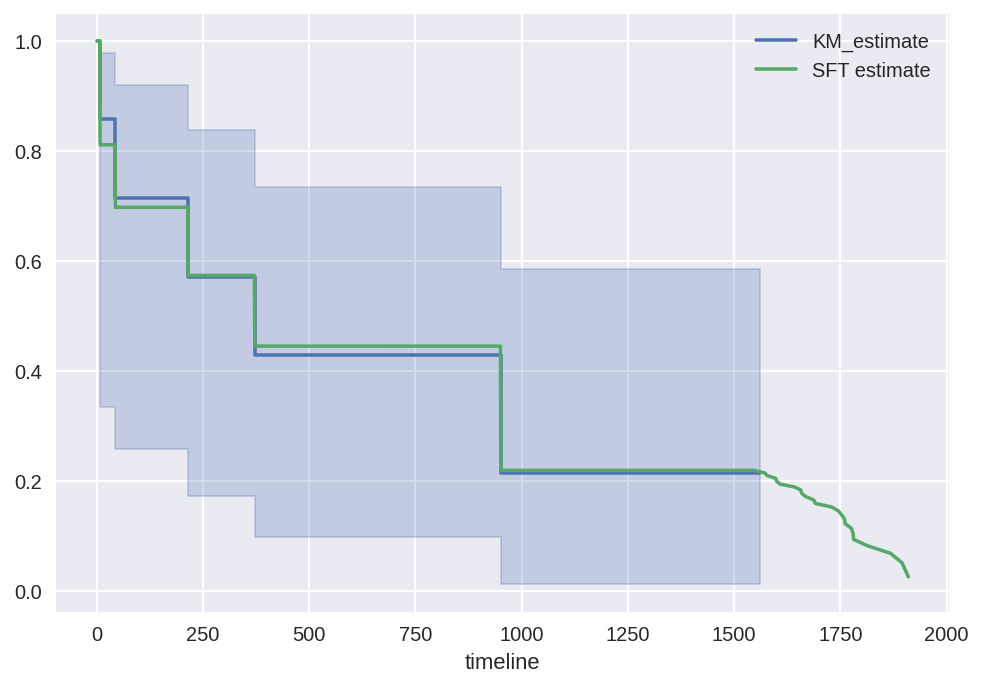

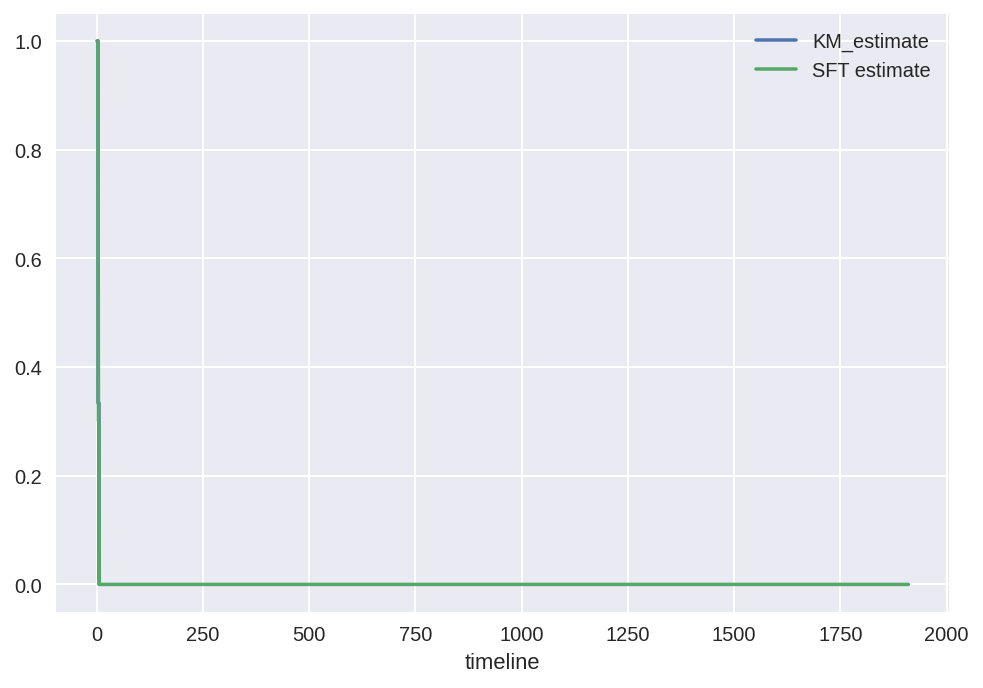

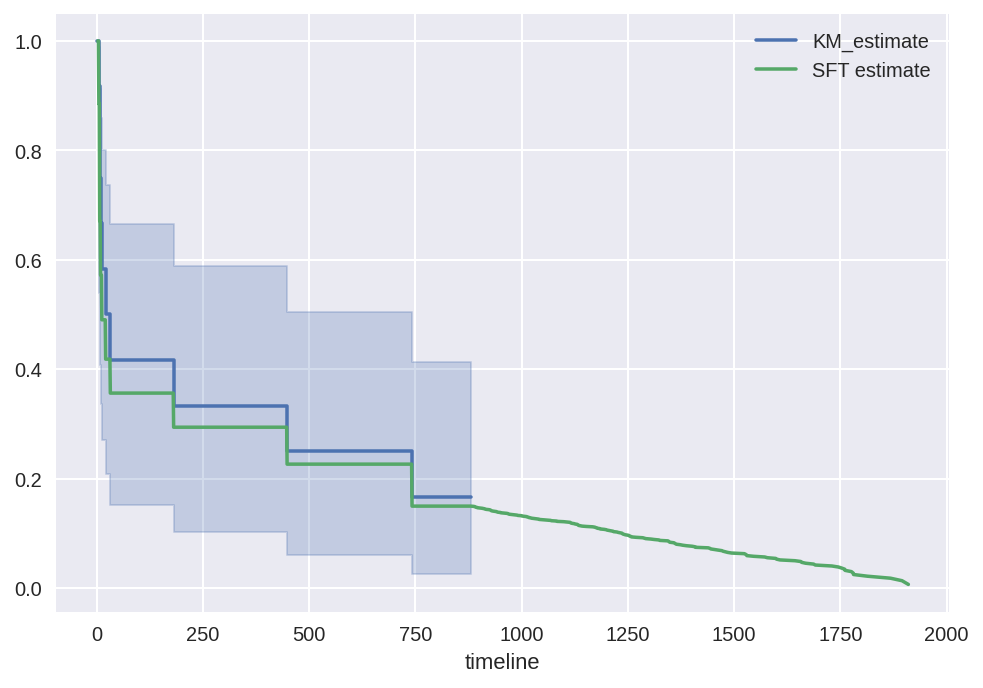

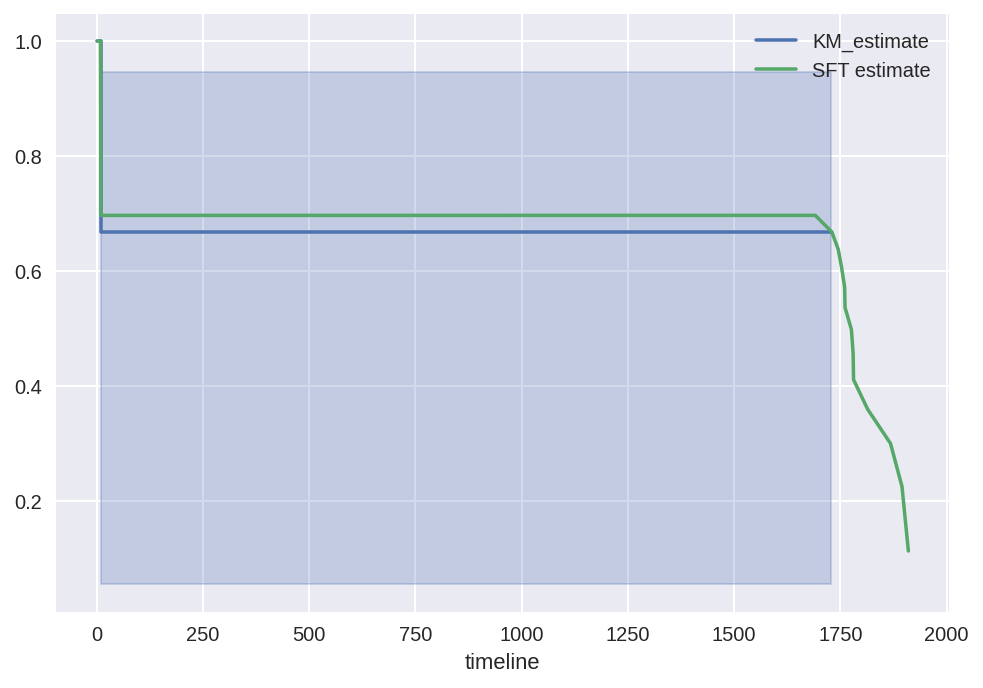

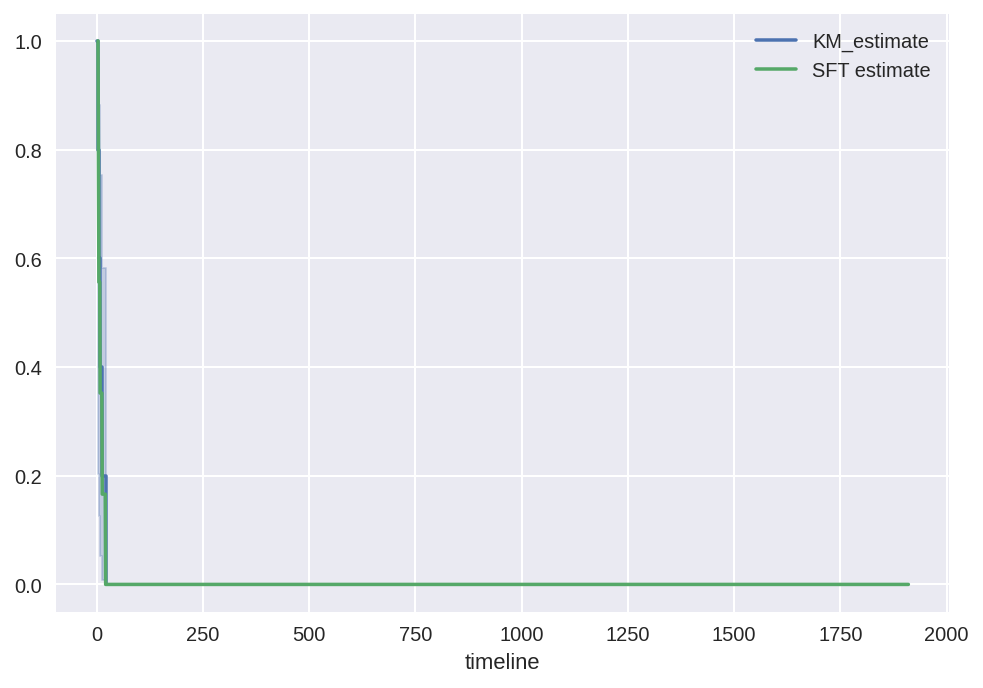

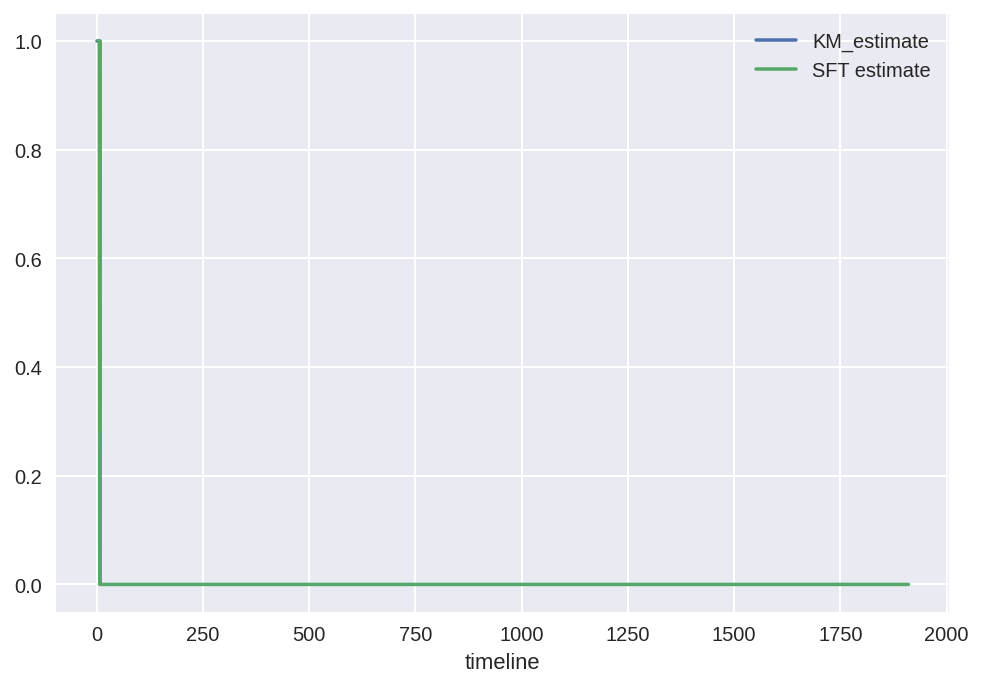

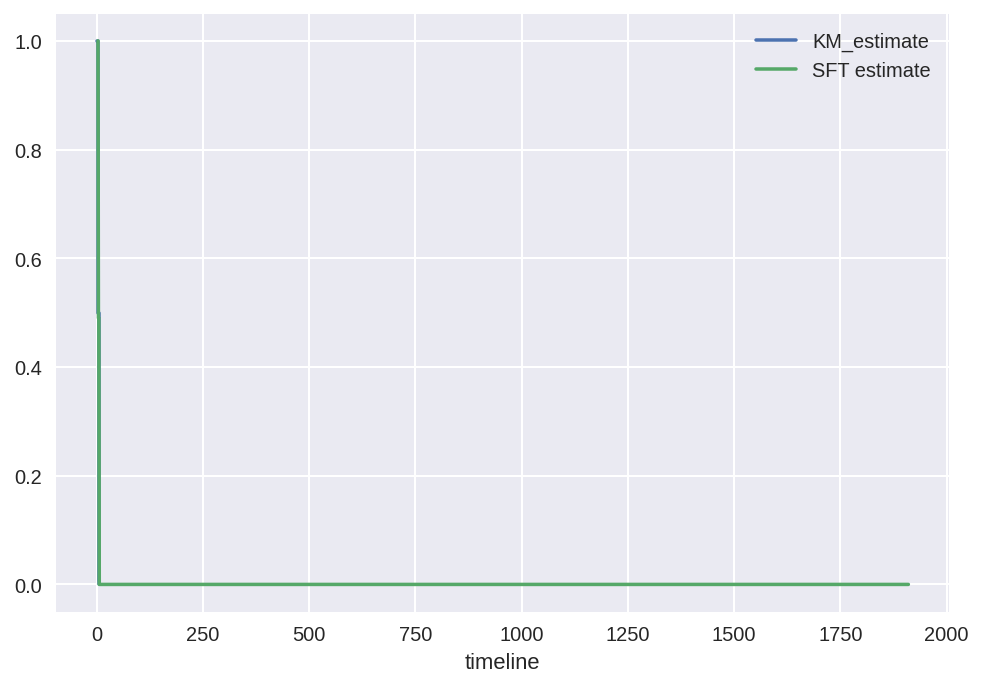

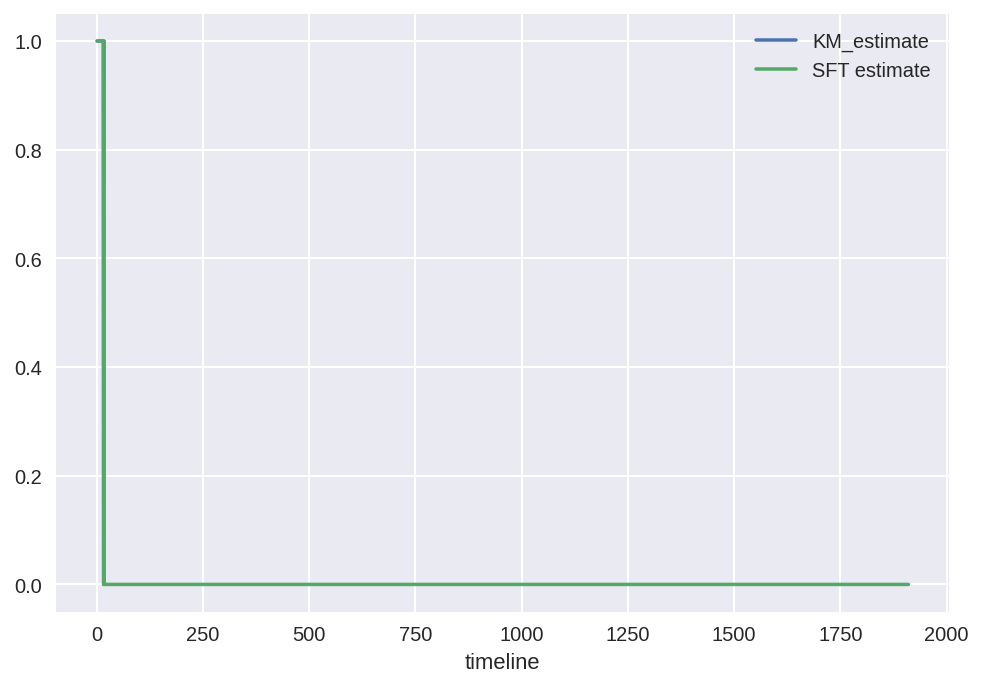

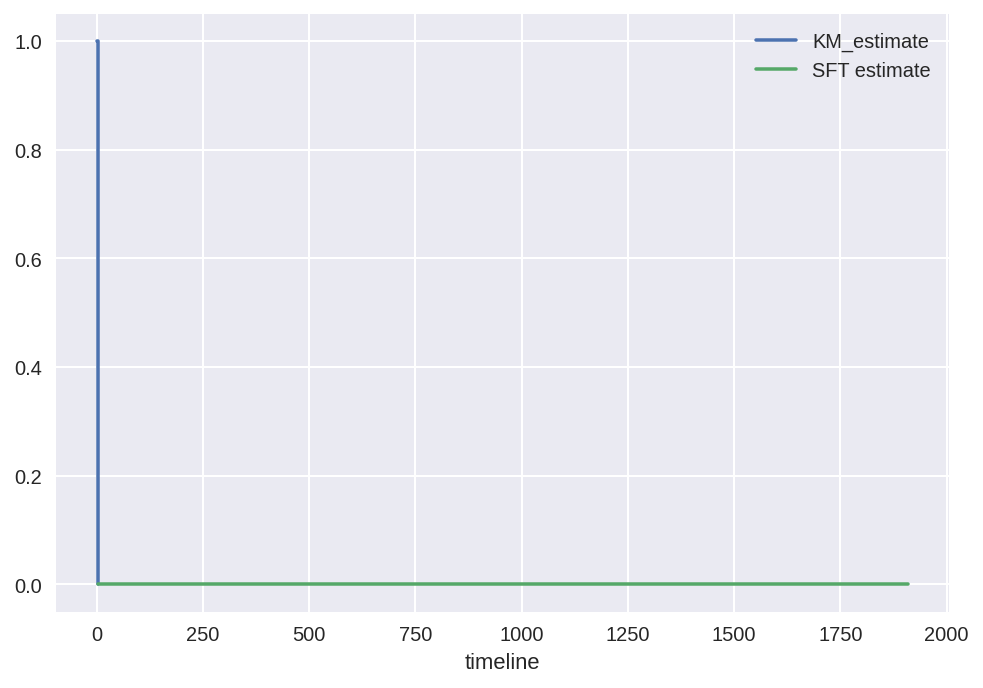

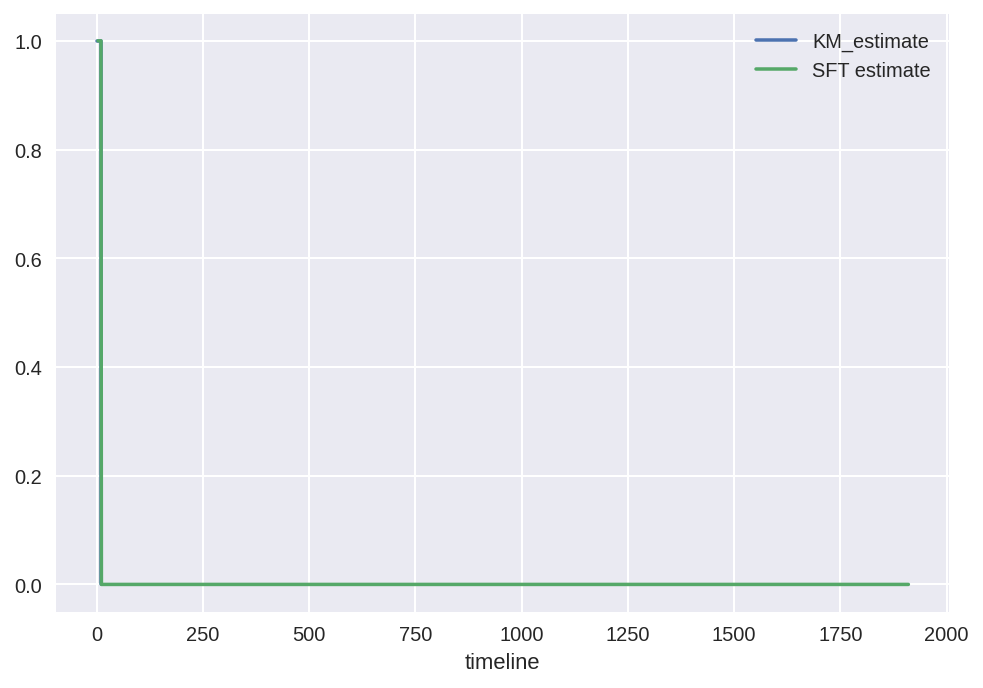

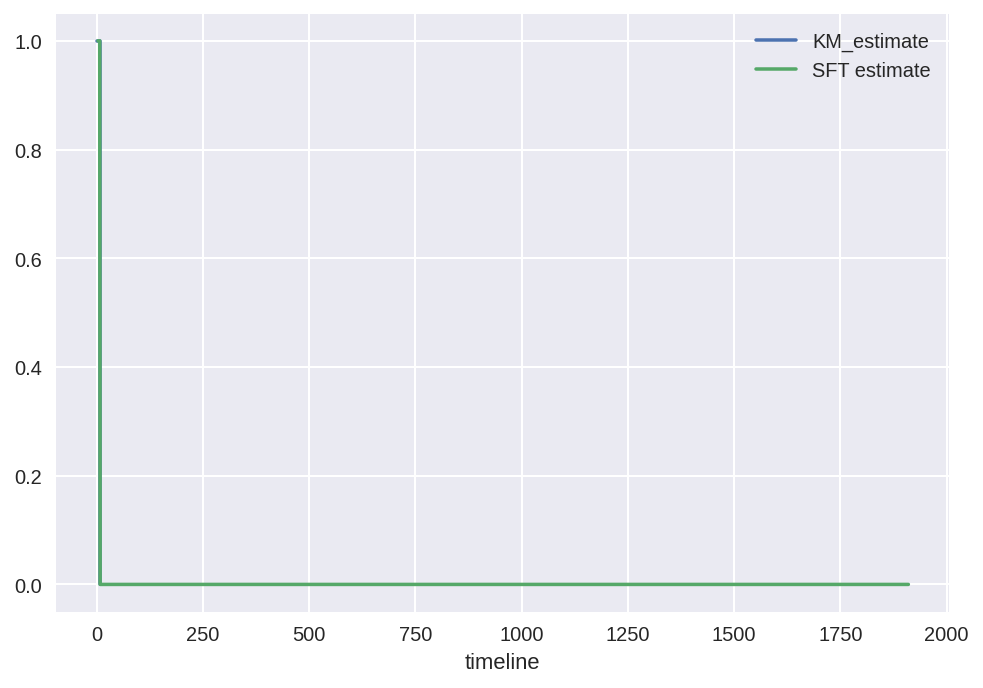

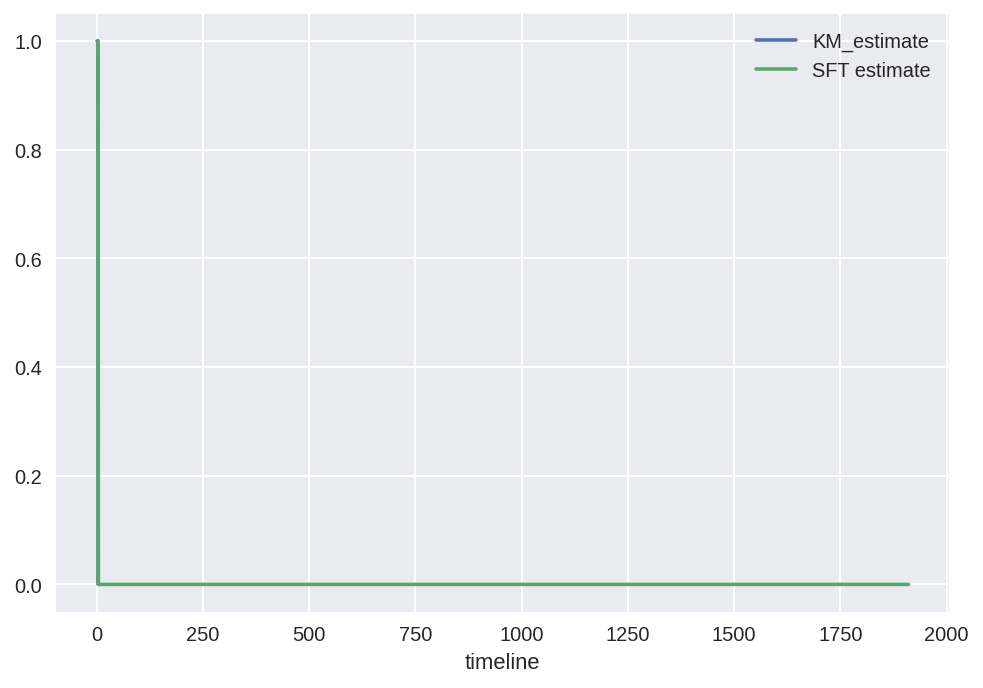

In [6]:
# this is just to compare each cluster's Kaplan-Meier survival curve with the summary fine-tuning survival curve
# (sometimes they are close but often they're quite different)
for exemplar_idx in range(n_exemplars):
    plt.figure()
    exemplar_kaplan_meier_curves[exemplar_idx].plot()
    plt.plot(duration_index, exemplar_SFT_survival_curves[exemplar_idx], label='SFT estimate')
    plt.legend()

In [7]:
# compute median survival times (look at where each survival curve crosses probability 1/2)
exemplar_SFT_median_survival_times = \
    compute_median_survival_times(exemplar_SFT_survival_curves, duration_index)

In [8]:
# discretizes features for heatmap visualization
transformed_features, transformed_feature_names, all_n_bins_to_use = transform(dataset, raw_features)

/heinz-georgenas/anaconda3/envs/base-2020/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/heinz-georgenas/anaconda3/envs/base-2020/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/heinz-georgenas/anaconda3/envs/base-2020/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:
n_top_clusters_to_visualize = 5

In [10]:
quadruples = \
    sorted([(idx, exemplar_sizes[idx],  exemplar_SFT_median_survival_times[idx], max_observed_times[idx])
            for idx in range(n_exemplars)], reverse=True, key=lambda x: x[1])[:n_top_clusters_to_visualize]
quadruples = sorted(quadruples, key=lambda x: x[2])  # sort by median survival time
quadruples

[(2, 499, 70.0, 2007.0),
 (12, 261, 104.0, 2026.0),
 (5, 1144, 322.0, 2027.0),
 (1, 335, 368.0, 1979.0),
 (0, 767, 1304.0, 2029.0)]

In [11]:
# fraction of training data that are in the top `n_top_clusters_to_visualize` largest clusters
np.sum([x[1] for x in quadruples]) / embeddings.shape[0]

0.605072463768116

### Cluster feature heatmap plot

In [12]:
colors = plt.cm.tab10.colors

In [13]:
exemplars_to_visualize = np.array(quadruples).T[0].astype(int)
examplars_to_visualize_cluster_sizes = np.array(quadruples).T[1].astype(int)
exemplars_to_visualize_median_survival_times = np.array(quadruples).T[2]
exemplars_to_visualize_max_observed_times = np.array(quadruples).T[3]

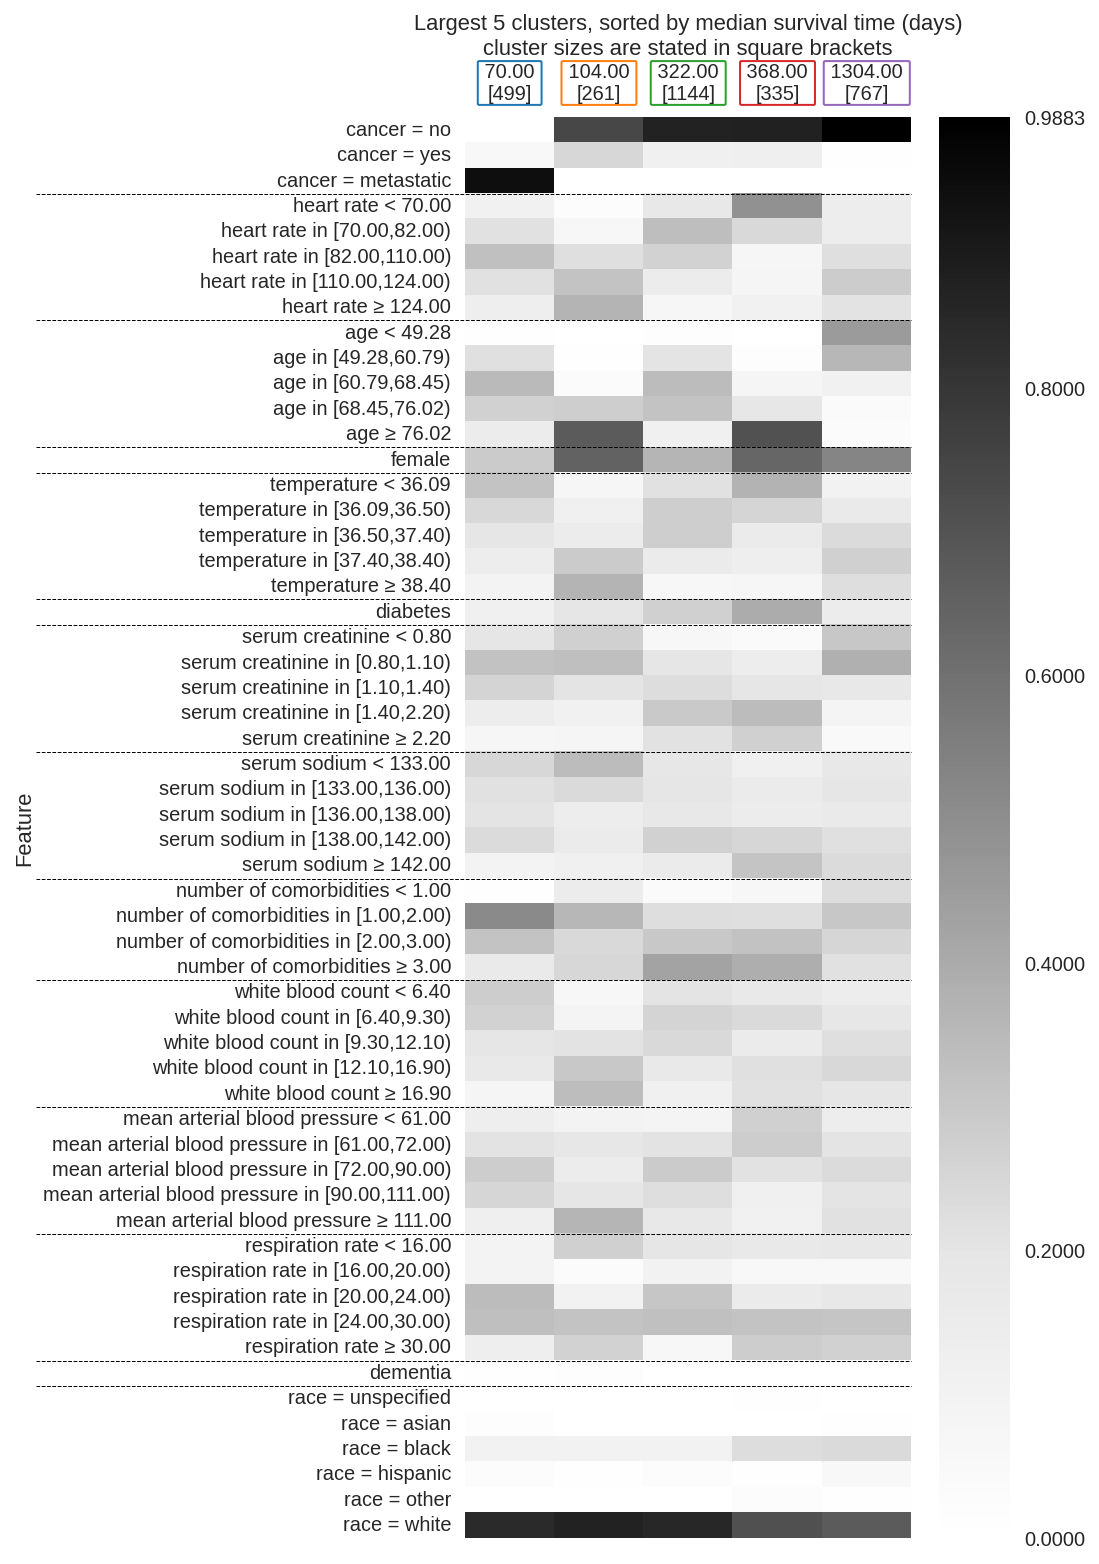

In [14]:
exemplar_assignments_in_terms_of_cluster_labels = np.zeros(raw_features.shape[0])
for idx, _ in enumerate(exemplar_assignments):
    exemplar_assignments_in_terms_of_cluster_labels[_] = idx

heatmap = np.zeros((len(transformed_feature_names), len(exemplars_to_visualize)))
for idx, exemplar_idx in enumerate(exemplars_to_visualize):
    heatmap[:, idx] = transformed_features[exemplar_assignments_in_terms_of_cluster_labels == exemplar_idx].mean(axis=0)

heatmap_plot(heatmap, exemplars_to_visualize_median_survival_times, transformed_feature_names,
             all_n_bins_to_use, max_observed_times=exemplars_to_visualize_max_observed_times,
             units=units,
             custom_xlabel="Largest %d clusters, sorted by median survival time (%s)\ncluster sizes are stated in square brackets"
                           % (n_top_clusters_to_visualize, units),
             cluster_sizes=examplars_to_visualize_cluster_sizes,
             axhline_xmin=-.96)
ax = plt.gca()
for ticklabel, color in zip(ax.get_xticklabels(), colors):
    ticklabel.set_bbox({'boxstyle': 'round', 'fill': False, 'edgecolor': color, 'linewidth': 1, 'pad': 0.07})
plt.savefig('clusters-heatmap-top%d-%s.pdf' % (n_top_clusters_to_visualize, dataset),
            bbox_inches='tight')

### Cluster survival curve plot (using summary functions from summary fine-tuning)

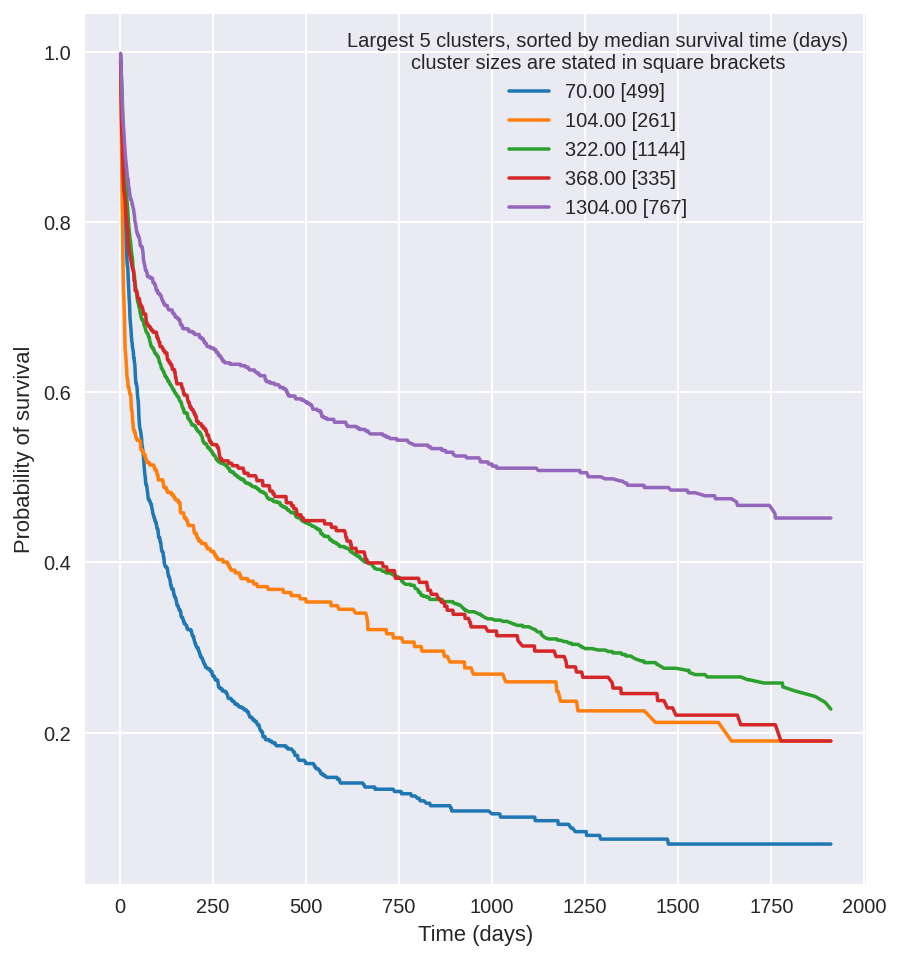

In [15]:
plt.figure(figsize=(7, 8))

# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set3.colors)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

for exemplar_idx, _, _, _ in quadruples:
    plt.plot(duration_index, exemplar_SFT_survival_curves[exemplar_idx], label='to be replaced')

L = plt.legend(title="Largest %d clusters, sorted by median survival time (%s)\ncluster sizes are stated in square brackets"
                     % (n_top_clusters_to_visualize, units))
plt.setp(L.get_title(), multialignment='center')
for idx, (exemplar_idx, cluster_size, _, max_observed_time) in enumerate(quadruples):
    if not np.isinf(exemplar_SFT_median_survival_times[exemplar_idx]):
        legend_text = '%.2f' % exemplar_SFT_median_survival_times[exemplar_idx]
    else:
        legend_text = '> %.2f' % max_observed_time
    legend_text += ' [%d]' % cluster_size
    L.get_texts()[idx].set_text(legend_text)
plt.xlabel('Time (%s)' % units)
plt.ylabel('Probability of survival')
plt.savefig('clusters-sft-survival-curves-top%d-%s.pdf' % (n_top_clusters_to_visualize, dataset),
            bbox_inches='tight')

### Clustering survival curve plot (using Kaplan-Meier curves -- corresponds to *not* using summary fine-tuning)

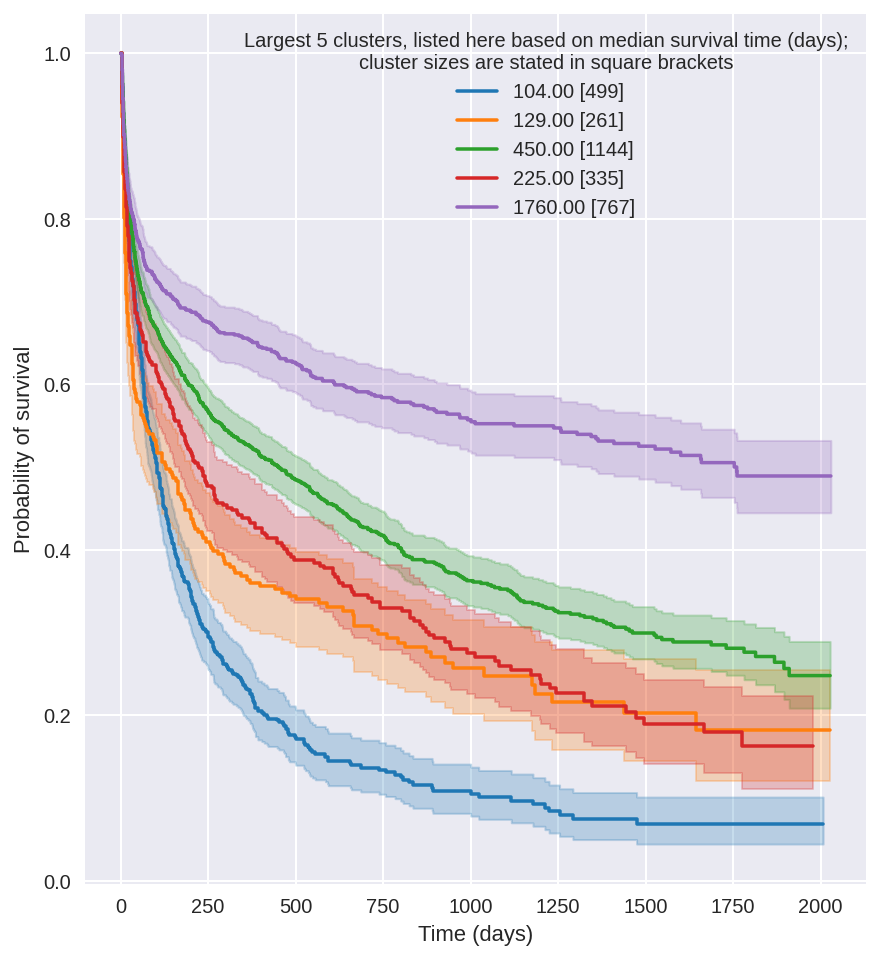

In [16]:
plt.figure(figsize=(7, 8))

# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set3.colors)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)
for exemplar_idx, _, _, _ in quadruples:
    exemplar_kaplan_meier_curves[exemplar_idx].plot()
L = plt.legend(title="Largest %d clusters, listed here based on median survival time (%s);\ncluster sizes are stated in square brackets"
                     % (n_top_clusters_to_visualize, units))
plt.setp(L.get_title(), multialignment='center')
for idx, (exemplar_idx, cluster_size, _, max_observed_time) in enumerate(quadruples):
    kaplan_meier_median_survival_time = exemplar_kaplan_meier_curves[exemplar_idx].median_survival_time_
    if not np.isinf(kaplan_meier_median_survival_time):
        legend_text = '%.2f' % kaplan_meier_median_survival_time
    else:
        legend_text = '> %.2f' % max_observed_time
    legend_text += ' [%d]' % cluster_size
    L.get_texts()[idx].set_text(legend_text)
plt.xlabel('Time (%s)' % units)
plt.ylabel('Probability of survival')
plt.savefig('clusters-km-sorted-by-sft-median-times-top%d-%s.pdf' % (n_top_clusters_to_visualize, dataset), bbox_inches='tight')

### Use agglomerative clustering to obtain superclusters for visualization

In [17]:
from sklearn.cluster import AgglomerativeClustering
n_superclusters = 10
cluster_model = AgglomerativeClustering(n_clusters=n_superclusters, linkage='complete')
cluster_model.fit(exemplar_embeddings)

AgglomerativeClustering(linkage='complete', n_clusters=10)

In [18]:
new_exemplar_assignments = [[] for cluster_idx in range(n_superclusters)]
for idx, _ in enumerate(exemplar_assignments):
    new_exemplar_assignments[cluster_model.labels_[idx]].extend(_)

In [19]:
[len(x) for x in new_exemplar_assignments]

[379, 2183, 168, 118, 1268, 1, 17, 1, 785, 48]

In [20]:
new_weighted_survival_curves = []
new_max_observed_times = []
for cluster_idx in range(n_superclusters):
    T, E = labels[new_exemplar_assignments[cluster_idx]].T
    new_max_observed_times.append(T.max())
    
    mask = (cluster_model.labels_ == cluster_idx)
    exemplar_indices = np.where(mask)[0]
    weights = []
    for exemplar_idx in exemplar_indices:
        weights.append(exemplar_sizes[exemplar_idx])
    weights = np.array(weights, dtype=float)
    weights = weights / weights.sum()
    weighted_survival_curve = np.zeros(exemplar_SFT_survival_curves.shape[1])
    for exemplar_idx, weight in zip(exemplar_indices, weights):
        weighted_survival_curve += weight * exemplar_SFT_survival_curves[exemplar_idx]
    new_weighted_survival_curves.append(weighted_survival_curve)

new_median_survival_times = \
    compute_median_survival_times(new_weighted_survival_curves, duration_index)

new_exemplar_assignments_in_terms_of_cluster_labels = np.zeros(raw_features.shape[0])
for idx, _ in enumerate(new_exemplar_assignments):
    new_exemplar_assignments_in_terms_of_cluster_labels[_] = idx

new_quadruples = \
    [(cluster_idx,
      len(new_exemplar_assignments[cluster_idx]),
      new_median_survival_times[cluster_idx],
      new_max_observed_times[cluster_idx])
     for cluster_idx in range(n_superclusters)]
new_quadruples = sorted(new_quadruples, key=lambda x: x[3])
new_quadruples = sorted(new_quadruples, reverse=False, key=lambda x: x[2])

new_exemplars_to_visualize = np.array(new_quadruples).T[0].astype(int)
new_exemplars_to_visualize_cluster_sizes = np.array(new_quadruples).T[1].astype(int)
new_exemplars_to_visualize_median_survival_times = np.array(new_quadruples).T[2]
new_exemplars_to_visualize_max_observed_times = np.array(new_quadruples).T[3]

new_heatmap = np.zeros((len(transformed_feature_names), len(new_exemplars_to_visualize)))
for idx, cluster_idx in enumerate(new_exemplars_to_visualize):
    new_heatmap[:, idx] = transformed_features[
        new_exemplar_assignments_in_terms_of_cluster_labels == cluster_idx].mean(axis=0)

new_quadruples

[(6, 17, 3.0, 1627.0),
 (2, 168, 23.0, 2016.0),
 (9, 48, 34.0, 1915.0),
 (0, 379, 40.0, 1975.0),
 (8, 785, 80.0, 2029.0),
 (1, 2183, 248.0, 2027.0),
 (4, 1268, 734.0, 2029.0),
 (5, 1, 1119.0, 442.0),
 (7, 1, 1177.0, 507.0),
 (3, 118, 1910.0, 2026.0)]

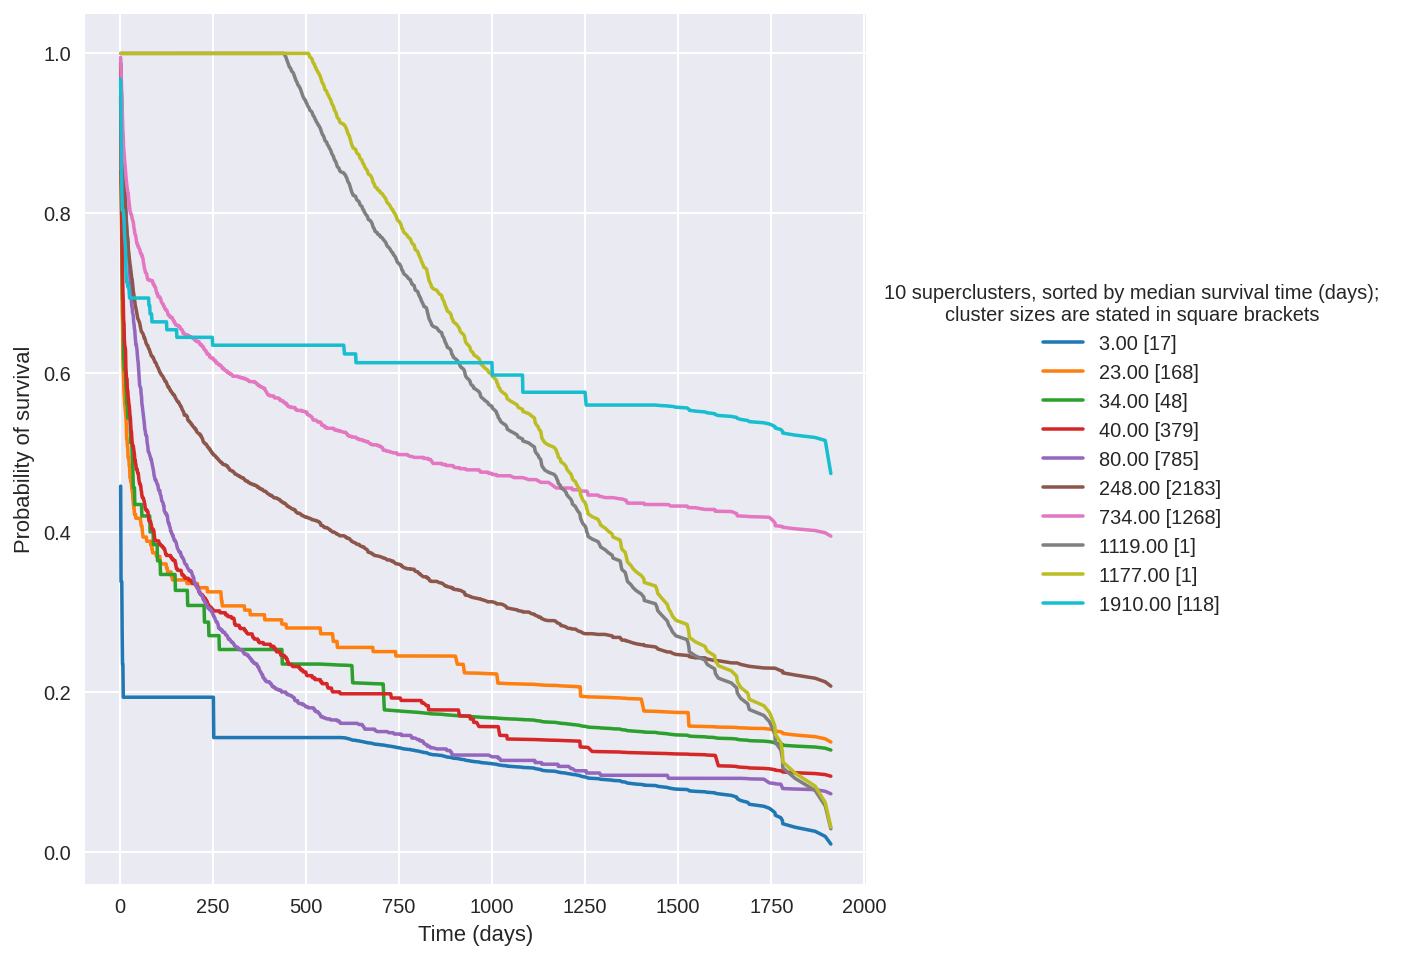

In [21]:
plt.figure(figsize=(7, 8))
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set3.colors)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)
for cluster_idx, _, _, _ in new_quadruples:
    plt.plot(duration_index, new_weighted_survival_curves[cluster_idx], label='to be replaced')
L = plt.legend(title="%d superclusters, sorted by median survival time (%s);\ncluster sizes are stated in square brackets"
                     % (n_superclusters, units),
               loc='center left', bbox_to_anchor=(1, 0.5))
plt.setp(L.get_title(), multialignment='center')
for idx, (_, cluster_size, exemplar_median_survival_time, max_observed_time) in enumerate(new_quadruples):
    if not np.isinf(exemplar_median_survival_time):
        legend_text = '%.2f' % exemplar_median_survival_time
    else:
        legend_text = '> %.2f' % max_observed_time
    legend_text += ' [%d]' % cluster_size
    L.get_texts()[idx].set_text(legend_text)
plt.xlabel('Time (%s)' % units)
plt.ylabel('Probability of survival')
plt.savefig('superclusters%d-sft-km-%s.pdf' % (n_superclusters, dataset),
            bbox_inches='tight')

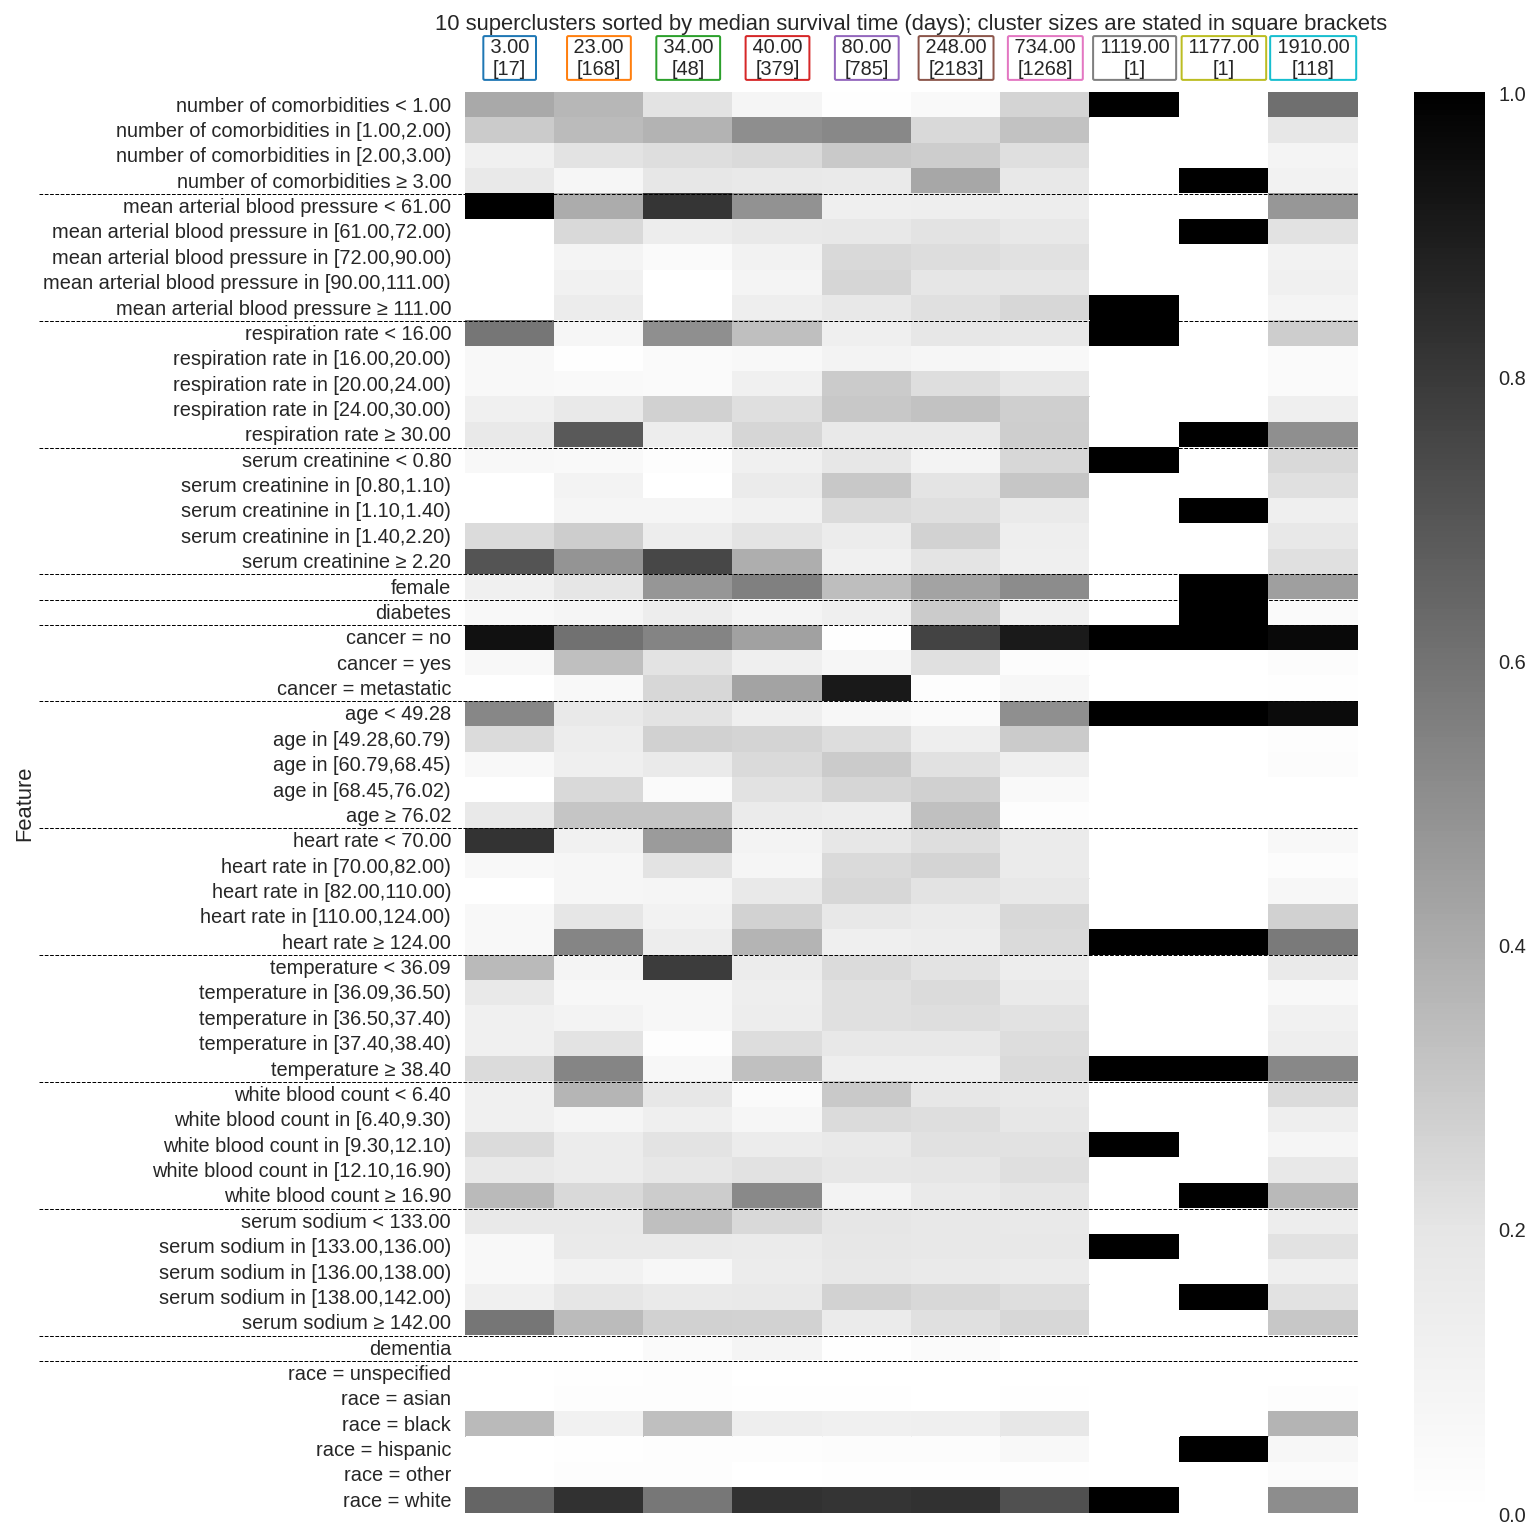

In [22]:
heatmap_plot(new_heatmap, new_exemplars_to_visualize_median_survival_times,
             transformed_feature_names, all_n_bins_to_use,
             max_observed_times=new_exemplars_to_visualize_max_observed_times,
             units=units, max_features_to_display=60,
             custom_xlabel='%d superclusters sorted by median survival time (%s); cluster sizes are stated in square brackets'
                           % (n_superclusters, units),
             cluster_sizes=new_exemplars_to_visualize_cluster_sizes,
             axhline_xmin=-.477)
ax = plt.gca()
for ticklabel, color in zip(ax.get_xticklabels(), colors):
    ticklabel.set_bbox({'boxstyle': 'round', 'fill': False, 'edgecolor': color, 'linewidth': 1, 'pad': 0.07})
plt.savefig('superclusters%d-sft-heatmap-%s.pdf' % (n_superclusters, dataset),
            bbox_inches='tight')